<a href="https://colab.research.google.com/github/nikita-bedi/HN-MRI-Segmentation/blob/main/Finalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Background


Head and neck cancers, particularly oropharyngeal carcinoma, are among the most challenging cancers to diagnose and treat- due to subtle presentation of tumor, and various treatment options.  Accurate tumor segmentation on MRI is critical for optimizing treatment planning, particularly radiation therapy planning. Manual segmentation is time-consuming, highly variable between observers, and a major burden in clinical workflows. To address this problem, I propose to develop a computer vision pipeline that automatically segments primary tumors and metastatic lymph nodes from T2-weighted MRI scans using deep learning.

### Objectives

The primary objective of this project is to develop an automated deep learning pipeline that accurately segments primary tumors (GTVp) and metastatic lymph nodes (GTVn) from T2-weighted MRI scans of patients with head and neck cancers.



## 1. Download Dataset


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from glob import glob
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import pickle as pkl
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import precision_score, recall_score, jaccard_score, f1_score


In [ ]:
#download dataset to google drive

dataset_folder = '/content/drive/MyDrive/cv_mr_data'
zip_file_path = '/content/drive/MyDrive/cv_mr_data.zip'

if not os.path.exists(dataset_folder):
    print("Dataset not found! Downloading now...")

    # Download the zip file
    !wget -O {zip_file_path} "https://zenodo.org/api/records/11199559/files-archive"

    print("Unzipping dataset...")
    # Create the dataset folder before unzipping
    os.makedirs(dataset_folder, exist_ok=True)
    !unzip {zip_file_path} -d {dataset_folder}
    !unzip /content/drive/MyDrive/cv_mr_data/HNTSMRG24_train.zip -d /content/drive/MyDrive/cv_mr_data/data
    print("Dataset download and extraction complete.")
else:
    print("Dataset already exists. Skipping download.")

Dataset already exists. Skipping download.


In [ ]:
!ls /content/drive/MyDrive/cv_mr_data

data  HNTSMRG24_train.zip  LICENSE.txt	README.md


In [ ]:
#unzip mri dataset
#!unzip /content/drive/MyDrive/cv_mr_data/HNTSMRG24_train.zip -d /content/drive/MyDrive/cv_mr_data/data

## 2. EDA and Data Pre-Processing


In [ ]:
# Dataset Paths
dataset_dir = '/content/drive/MyDrive/cv_mr_data/data/HNTSMRG24_train/'

# Check first few files
print("Files in dataset directory:")
print(os.listdir(dataset_dir)[:10])



Files in dataset directory:
['95', '96', '99', '101', '103', '104', '105', '107', '108', '109']


In [ ]:
# check directory structure of dataset_dir and print first few full set
print("Directory structure of dataset_dir (first 3 top-level folders):")

# Get the first 3 immediate subdirectories
top_level_dirs = [
    d for d in os.listdir(dataset_dir)
    if os.path.isdir(os.path.join(dataset_dir, d))
][:3]

# Walk through each of them deeply
for top_dir in top_level_dirs:
    full_top_dir = os.path.join(dataset_dir, top_dir)
    for root, dirs, files in os.walk(full_top_dir):
        level = root.replace(dataset_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        sub_indent = ' ' * 4 * (level + 1)
        for f in files:
            print(f"{sub_indent}{f}")

Directory structure of dataset_dir (first 3 top-level folders):
95/
    midRT/
        95_midRT_T2.nii.gz
        95_midRT_mask.nii.gz
    preRT/
        95_preRT_T2.nii.gz
        95_preRT_mask.nii.gz
96/
    midRT/
        96_midRT_T2.nii.gz
        96_midRT_mask.nii.gz
    preRT/
        96_preRT_T2.nii.gz
        96_preRT_mask.nii.gz
99/
    midRT/
        99_midRT_T2.nii.gz
        99_midRT_mask.nii.gz
    preRT/
        99_preRT_mask.nii.gz
        99_preRT_T2.nii.gz


The dataset includes registered pre-treatment (preRT) scans and masks within the midRT folders. These represent spatially aligned versions of the preRT data and are not independent imaging timepoints. We will exclude the registered scans and masks from our dataset to avoid double-counting and prevent spatial leakage.

Additionally, some patients in the dataset present with unknown primary tumors or exhibit complete treatment response at mid-treatment, resulting in empty segmentation masks. To ensure that our model generalizes well and does not overfit to specific case types, we will carefully inspect and record the presence of tumor and nodal disease in each case. The dataset is then split at the patient level into training, validation, and test sets with a balanced distribution of tumor types, including cases with GTVp only, GTVn only, both, or no visible disease.

In [ ]:
#exclude _registered files from out dataset directory

def exclude_registered_files(root_dir):
    for patient_folder in os.listdir(root_dir):
        patient_path = os.path.join(root_dir, patient_folder)
        if os.path.isdir(patient_path):
            for subfolder in ['preRT', 'midRT']:
                subfolder_path = os.path.join(patient_path, subfolder)
                if os.path.exists(subfolder_path):
                    for file in os.listdir(subfolder_path):
                        if file.endswith('_registered.nii.gz'):
                            #remove file
                            file_path = os.path.join(subfolder_path, file)
                            os.remove(file_path)
                            print(f"Removed: {file_path}")

exclude_registered_files(dataset_dir)



In [ ]:
#create dataframe that has patient folder, file name of preRT folder: scan, mask and paths,and file name of all files in midRT folder: scans, masks, and paths
def extract_metadata(root_dir):
    metadata = {
        'patient_folder': [],
        'preRT_scan_filename': [],
        'preRT_mask_filename': [],
        'preRT_scan_path': [],
        'preRT_mask_path': [],
        'midRT_scan_filename': [],
        'midRT_mask_filename': [],
        'midRT_scan_path': [],
        'midRT_mask_path': [],
    }

    for patient_folder in sorted(os.listdir(root_dir)):
        patient_path = os.path.join(root_dir, patient_folder)
        if os.path.isdir(patient_path):
            preRT_path = os.path.join(patient_path, 'preRT')
            midRT_path = os.path.join(patient_path, 'midRT')

            # Initialize fields
            preRT_scan_file = ''
            preRT_mask_file = ''
            midRT_scan_file = ''
            midRT_mask_file = ''

            # Handle preRT
            if os.path.exists(preRT_path):
                preRT_scan_files = [f for f in os.listdir(preRT_path) if f.endswith('T2.nii.gz')]
                preRT_mask_files = [f for f in os.listdir(preRT_path) if f.endswith('mask.nii.gz')]

                if preRT_scan_files and preRT_mask_files:
                    preRT_scan_file = preRT_scan_files[0]
                    preRT_mask_file = preRT_mask_files[0]

            # Handle midRT (exclude registered preRT files)
            if os.path.exists(midRT_path):
                midRT_scan_files = [f for f in os.listdir(midRT_path) if f.endswith('T2.nii.gz') and 'preRT' not in f]
                midRT_mask_files = [f for f in os.listdir(midRT_path) if f.endswith('mask.nii.gz') and 'preRT' not in f]

                if midRT_scan_files and midRT_mask_files:
                    midRT_scan_file = midRT_scan_files[0]
                    midRT_mask_file = midRT_mask_files[0]

            # Only add if both preRT and midRT entries exist
            if preRT_scan_file and preRT_mask_file and midRT_scan_file and midRT_mask_file:
                metadata['patient_folder'].append(patient_folder)
                metadata['preRT_scan_filename'].append(preRT_scan_file)
                metadata['preRT_mask_filename'].append(preRT_mask_file)
                metadata['preRT_scan_path'].append(os.path.join(preRT_path, preRT_scan_file))
                metadata['preRT_mask_path'].append(os.path.join(preRT_path, preRT_mask_file))
                metadata['midRT_scan_filename'].append(midRT_scan_file)
                metadata['midRT_mask_filename'].append(midRT_mask_file)
                metadata['midRT_scan_path'].append(os.path.join(midRT_path, midRT_scan_file))
                metadata['midRT_mask_path'].append(os.path.join(midRT_path, midRT_mask_file))

    metadata_df = pd.DataFrame(metadata)
    return metadata_df

records_df = extract_metadata(dataset_dir)
display(records_df.head())
records_df.to_csv('/content/drive/MyDrive/cv_mr_data/data/records.csv', index=False)
display(records_df.info())







patient_folder  preRT_scan_filename    preRT_mask_filename  \
0             10   10_preRT_T2.nii.gz   10_preRT_mask.nii.gz   
1            101  101_preRT_T2.nii.gz  101_preRT_mask.nii.gz   
2            103  103_preRT_T2.nii.gz  103_preRT_mask.nii.gz   
3            104  104_preRT_T2.nii.gz  104_preRT_mask.nii.gz   
4            105  105_preRT_T2.nii.gz  105_preRT_mask.nii.gz   

                                     preRT_scan_path  \
0  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
1  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
2  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
3  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
4  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   

                                     preRT_mask_path  midRT_scan_filename  \
0  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   10_midRT_T2.nii.gz   
1  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...  101_midRT_T2.nii.gz   
2  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...  103_midRT_T2.nii.gz   
3  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...  104_midRT_T2.nii.gz   
4  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...  105_midRT_T2.nii.gz   

     midRT_mask_filename                                    midRT_scan_path  \
0   10_midRT_mask.nii.gz  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
1  101_midRT_mask.nii.gz  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
2  103_midRT_mask.nii.gz  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
3  104_midRT_mask.nii.gz  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
4  105_midRT_mask.nii.gz  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   

                                     midRT_mask_path  
0  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...  
1  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...  
2  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...  
3  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...  
4  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   patient_folder       150 non-null    object
 1   preRT_scan_filename  150 non-null    object
 2   preRT_mask_filename  150 non-null    object
 3   preRT_scan_path      150 non-null    object
 4   preRT_mask_path      150 non-null    object
 5   midRT_scan_filename  150 non-null    object
 6   midRT_mask_filename  150 non-null    object
 7   midRT_scan_path      150 non-null    object
 8   midRT_mask_path      150 non-null    object
dtypes: object(9)
memory usage: 10.7+ KB


None

In [ ]:
#get tumor volumes to see if empty mask or not and add to metadata
def get_tumor_volume(mask_path):
    mask_data = nib.load(mask_path).get_fdata()
    total_volume = np.sum(mask_data > 0)  # non-zero = any tumor
    gtvp_volume = np.sum(mask_data == 1)
    gtvn_volume = np.sum(mask_data == 2)
    return total_volume, gtvp_volume, gtvn_volume

# Load existing records with paths
records_df = pd.read_csv('/content/drive/MyDrive/cv_mr_data/data/records.csv')

# New list to hold updated rows
updated_records = []

for idx, row in records_df.iterrows():
    # Process preRT
    pre_total, pre_gtvp, pre_gtvn = get_tumor_volume(row['preRT_mask_path'])
    updated_records.append({
        'patient_folder': row['patient_folder'],
        'timepoint': 'preRT',
        'scan_path': row['preRT_scan_path'],
        'mask_path': row['preRT_mask_path'],
        'tumor_volume': pre_total,
        'gtvp_volume': pre_gtvp,
        'gtvn_volume': pre_gtvn
    })

    # Process midRT
    mid_total, mid_gtvp, mid_gtvn = get_tumor_volume(row['midRT_mask_path'])
    updated_records.append({
        'patient_folder': row['patient_folder'],
        'timepoint': 'midRT',
        'scan_path': row['midRT_scan_path'],
        'mask_path': row['midRT_mask_path'],
        'tumor_volume': mid_total,
        'gtvp_volume': mid_gtvp,
        'gtvn_volume': mid_gtvn
    })

# Create the updated metadata DataFrame
metadata_df = pd.DataFrame(updated_records)

# Save to CSV
metadata_df.to_csv('/content/drive/MyDrive/cv_mr_data/data/metadata.csv', index=False)

# Preview
display(metadata_df.head())
metadata_df.info()


patient_folder timepoint  \
0              10     preRT   
1              10     midRT   
2             101     preRT   
3             101     midRT   
4             103     preRT   

                                           scan_path  \
0  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
1  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
2  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
3  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
4  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   

                                           mask_path  tumor_volume  \
0  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         26867   
1  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         25215   
2  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         25550   
3  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         13638   
4  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         45298   

   gtvp_volume  gtvn_volume  
0         8009        18858  
1         1490        23725  
2         3051        22499  
3            0        13638  
4         8277        37021

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   patient_folder  300 non-null    int64 
 1   timepoint       300 non-null    object
 2   scan_path       300 non-null    object
 3   mask_path       300 non-null    object
 4   tumor_volume    300 non-null    int64 
 5   gtvp_volume     300 non-null    int64 
 6   gtvn_volume     300 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 16.5+ KB


In [ ]:
metadata_df=pd.read_csv('/content/drive/MyDrive/cv_mr_data/data/metadata.csv')
#get list of patients where gtvp is 0
no_primary_tumor=metadata_df[metadata_df['gtvp_volume']==0]
display(no_primary_tumor.head())
#get unique patient_folder
no_primary_tumor_patients=no_primary_tumor['patient_folder'].unique()
print(f"Number of patients with no primary tumor: {len(no_primary_tumor_patients)}")
print(f"Patients with no primary tumor: {no_primary_tumor_patients}")

#list of patients where gtvn is 0
no_node_tumor=metadata_df[metadata_df['gtvn_volume']==0]
display(no_node_tumor.head())
#get unique patient_folder
no_node_tumor_patients=no_node_tumor['patient_folder'].unique()
print(f"Number of patients with no nodal tumor: {len(no_node_tumor_patients)}")
print(f"Patients with no nodal tumor: {no_node_tumor_patients}")

patient_folder timepoint  \
3              101     midRT   
9              105     midRT   
10             107     preRT   
11             107     midRT   
33             118     midRT   

                                            scan_path  \
3   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
9   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
10  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
11  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
33  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   

                                            mask_path  tumor_volume  \
3   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         13638   
9   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         22454   
10  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...          5660   
11  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...          2327   
33  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         13426   

    gtvp_volume  gtvn_volume  
3             0        13638  
9             0        22454  
10            0         5660  
11            0         2327  
33            0        13426

Number of patients with no primary tumor: 36
Patients with no primary tumor: [101 105 107 118 129 136 139 148 152 154 165 174 177  18 187 188 190 191
 196  21  25  29  34  42  45  46  47  48   5  52  56  71   8  86  94  95]


patient_folder timepoint  \
52              132     preRT   
53              132     midRT   
92              156     preRT   
93              156     midRT   
104             164     preRT   

                                             scan_path  \
52   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
53   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
92   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
93   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
104  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   

                                             mask_path  tumor_volume  \
52   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...          5743   
53   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...          2608   
92   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         11193   
93   /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...          4080   
104  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...          3044   

     gtvp_volume  gtvn_volume  
52          5743            0  
53          2608            0  
92         11193            0  
93          4080            0  
104         3044            0

Number of patients with no nodal tumor: 21
Patients with no nodal tumor: [132 156 164 170 171 178 179 181 183 197  20  21  22  23  25  29  42  55
  64  77  80]


In [ ]:
#flag any patients with both empty primary tumor and empty mask
empty_mask_patients = metadata_df[
    (metadata_df['gtvp_volume'] == 0) &
    (metadata_df['gtvn_volume'] == 0)
]['patient_folder'].unique()

print(f"Number of patients with completely empty masks: {len(empty_mask_patients)}")
print(f"Patients with empty masks: {empty_mask_patients}")
#get files names of empty masks
empty_mask_files = metadata_df[
    (metadata_df['gtvp_volume'] == 0) &
    (metadata_df['gtvn_volume'] == 0)
]['mask_path'].unique()
print(f"Files names of empty masks: {empty_mask_files}")

Number of patients with completely empty masks: 4
Patients with empty masks: [21 25 29 42]
Files names of empty masks: ['/content/drive/MyDrive/cv_mr_data/data/HNTSMRG24_train/21/midRT/21_midRT_mask.nii.gz'
 '/content/drive/MyDrive/cv_mr_data/data/HNTSMRG24_train/25/midRT/25_midRT_mask.nii.gz'
 '/content/drive/MyDrive/cv_mr_data/data/HNTSMRG24_train/29/midRT/29_midRT_mask.nii.gz'
 '/content/drive/MyDrive/cv_mr_data/data/HNTSMRG24_train/42/midRT/42_midRT_mask.nii.gz']


These 4 patients have empty masks in midRT, which is to be expected if the patient is responding to the radiation treatment. Thus we will keep these files in our dataset.

In [ ]:
metadata_df=pd.read_csv('/content/drive/MyDrive/cv_mr_data/data/metadata.csv')
records_df=pd.read_csv('/content/drive/MyDrive/cv_mr_data/data/records.csv')

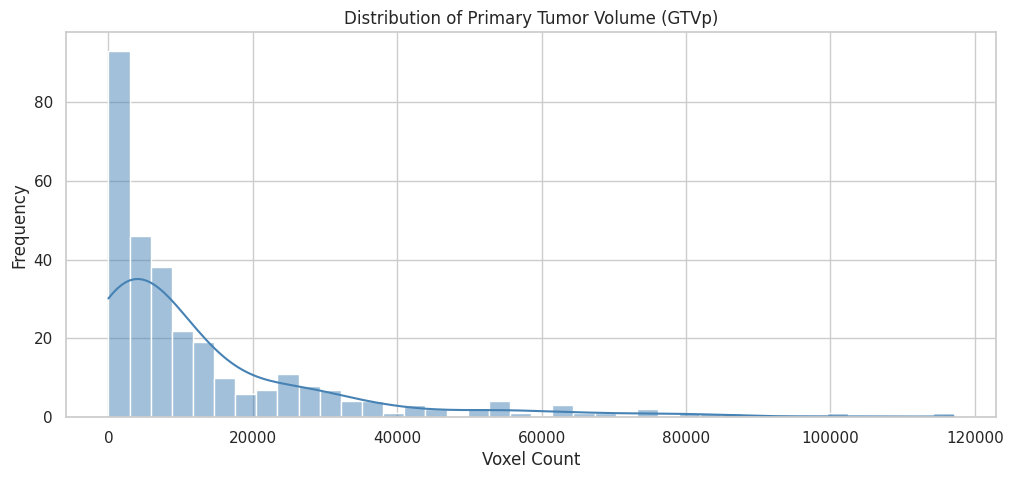

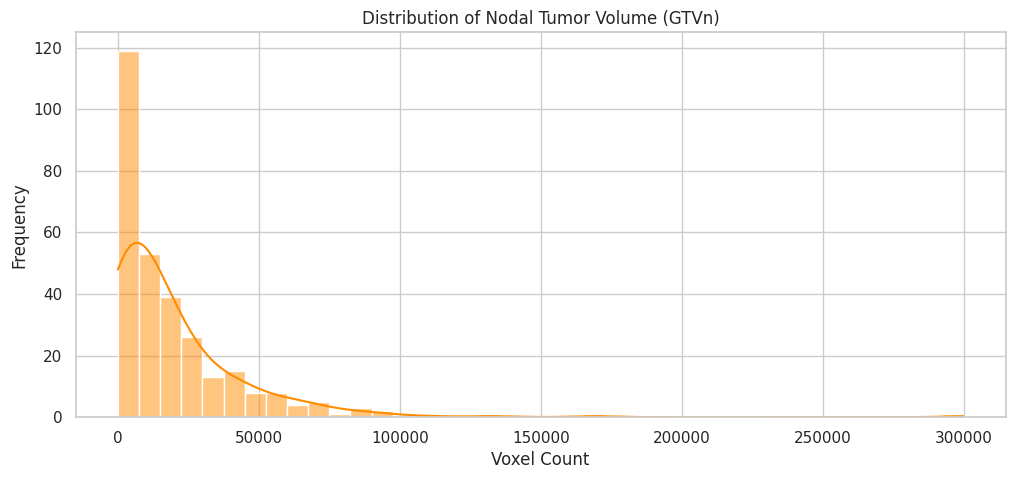

<ipython-input-6-47431b5f1192>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata_df, x="tumor_type", palette="Set2")


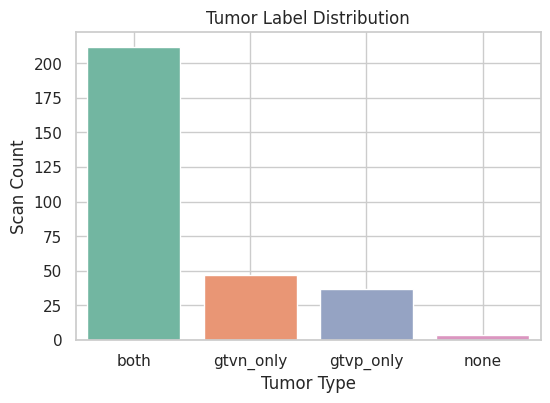

<ipython-input-6-47431b5f1192>:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metadata_df, x="timepoint", y="gtvp_volume", palette="Blues")


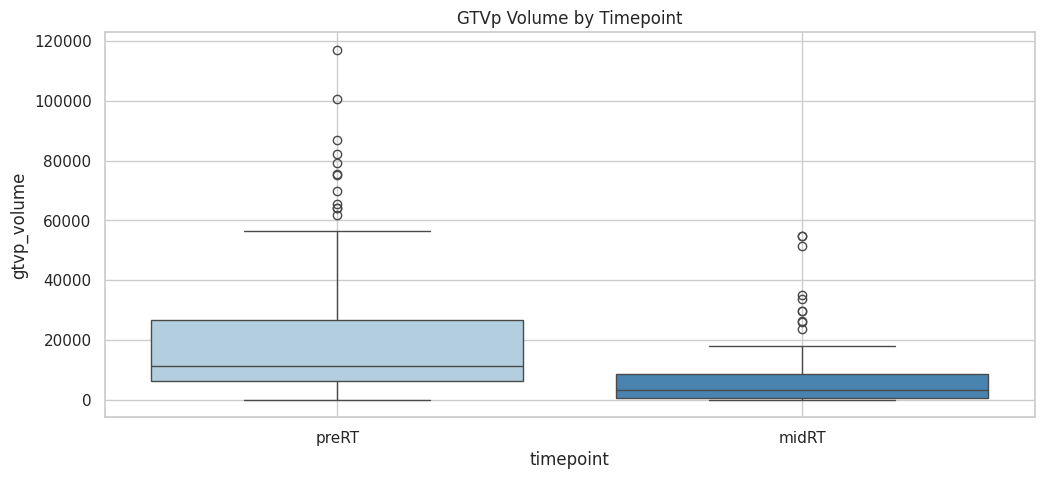

<ipython-input-6-47431b5f1192>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=metadata_df, x="timepoint", y="gtvn_volume", palette="Oranges")


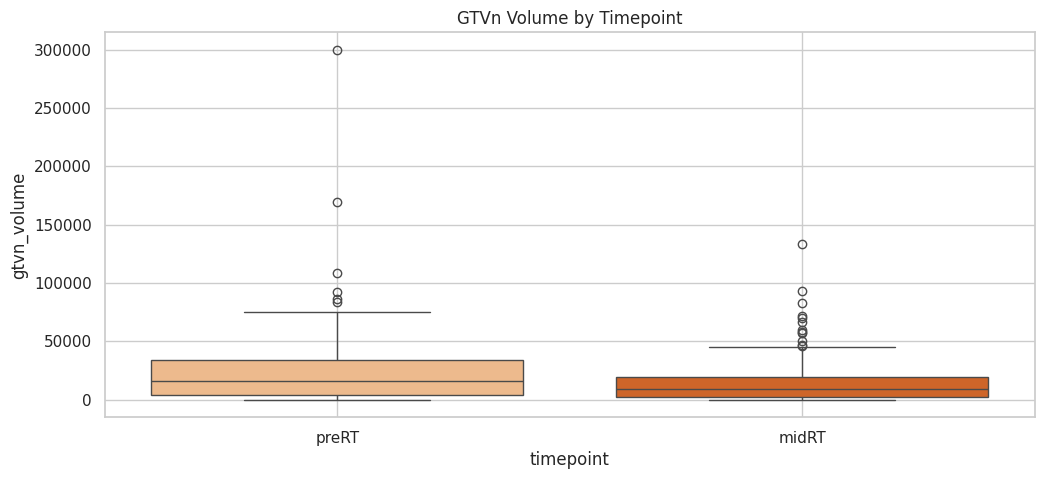

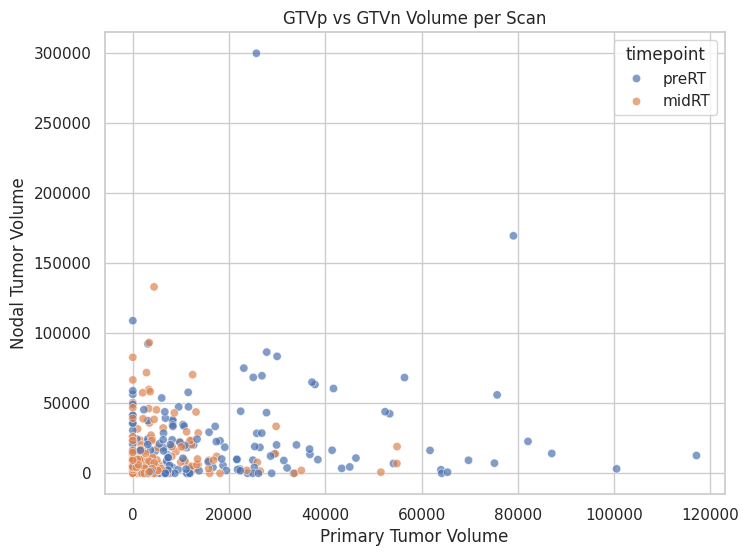

In [ ]:
sns.set(style="whitegrid")

# Basic distributions
plt.figure(figsize=(12, 5))
sns.histplot(data=metadata_df, x="gtvp_volume", bins=40, kde=True, color="steelblue")
plt.title("Distribution of Primary Tumor Volume (GTVp)")
plt.xlabel("Voxel Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(data=metadata_df, x="gtvn_volume", bins=40, kde=True, color="darkorange")
plt.title("Distribution of Nodal Tumor Volume (GTVn)")
plt.xlabel("Voxel Count")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Tumor presence combinations
metadata_df["has_gtvp"] = metadata_df["gtvp_volume"] > 0
metadata_df["has_gtvn"] = metadata_df["gtvn_volume"] > 0

# Combination category
metadata_df["tumor_type"] = metadata_df.apply(
    lambda row: "both" if row["has_gtvp"] and row["has_gtvn"]
    else "gtvp_only" if row["has_gtvp"]
    else "gtvn_only" if row["has_gtvn"]
    else "none", axis=1
)

plt.figure(figsize=(6, 4))
sns.countplot(data=metadata_df, x="tumor_type", palette="Set2")
plt.title("Tumor Label Distribution")
plt.ylabel("Scan Count")
plt.xlabel("Tumor Type")
plt.grid(True)
plt.show()

# Timepoint comparison
plt.figure(figsize=(12, 5))
sns.boxplot(data=metadata_df, x="timepoint", y="gtvp_volume", palette="Blues")
plt.title("GTVp Volume by Timepoint")
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
sns.boxplot(data=metadata_df, x="timepoint", y="gtvn_volume", palette="Oranges")
plt.title("GTVn Volume by Timepoint")
plt.grid(True)
plt.show()

# Scatterplot of primary vs nodal
plt.figure(figsize=(8, 6))
sns.scatterplot(data=metadata_df, x="gtvp_volume", y="gtvn_volume", hue="timepoint", alpha=0.7)
plt.title("GTVp vs GTVn Volume per Scan")
plt.xlabel("Primary Tumor Volume")
plt.ylabel("Nodal Tumor Volume")
plt.grid(True)
plt.show()


Next we evaluate the MRI and mask pairs and look at the voxels as well to see if any normalization or standardization needs to take place.

In [ ]:
#Create a MRI data and mask set class
class MRIDataset(Dataset):
    def __init__(self, root_dir, use_preRT=True, use_midRT=True, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.use_preRT = use_preRT
        self.use_midRT = use_midRT

        self.mri_files = []
        self.mask_files = []

        for patient_folder in sorted(os.listdir(root_dir)):
            patient_path = os.path.join(root_dir, patient_folder)
            if os.path.isdir(patient_path):

                if self.use_preRT:
                    preRT_path = os.path.join(patient_path, 'preRT')
                    if os.path.exists(preRT_path):
                        mri_files = [f for f in os.listdir(preRT_path) if f.endswith('T2.nii.gz')]
                        mask_files = [f for f in os.listdir(preRT_path) if f.endswith('mask.nii.gz')]
                        if len(mri_files) == 1 and len(mask_files) == 1:
                            self.mri_files.append(os.path.join(preRT_path, mri_files[0]))
                            self.mask_files.append(os.path.join(preRT_path, mask_files[0]))

                if self.use_midRT:
                    midRT_path = os.path.join(patient_path, 'midRT')
                    if os.path.exists(midRT_path):
                        mri_files = [f for f in os.listdir(midRT_path) if f.endswith('T2.nii.gz')]
                        mask_files = [f for f in os.listdir(midRT_path) if f.endswith('mask.nii.gz')]
                        if len(mri_files) == 1 and len(mask_files) == 1:
                            self.mri_files.append(os.path.join(midRT_path, mri_files[0]))
                            self.mask_files.append(os.path.join(midRT_path, mask_files[0]))

        assert len(self.mri_files) == len(self.mask_files), "Mismatch between MRI and Mask files!"

    def __len__(self):
        return len(self.mri_files)

    def __getitem__(self, idx):
        mri_path = self.mri_files[idx]
        mask_path = self.mask_files[idx]

        mri = nib.load(mri_path).get_fdata()
        mask = nib.load(mask_path).get_fdata()

        mri = (mri - np.mean(mri)) / (np.std(mri) + 1e-5)

        mri_tensor = torch.tensor(mri, dtype=torch.float32).unsqueeze(0)
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)

        return mri_tensor, mask_tensor

In [ ]:
#Number of MRI-Mask pairs
full_dataset = MRIDataset(dataset_dir)
print(f"Number of MRI-Mask pairs: {len(full_dataset)}")

Number of MRI-Mask pairs: 300


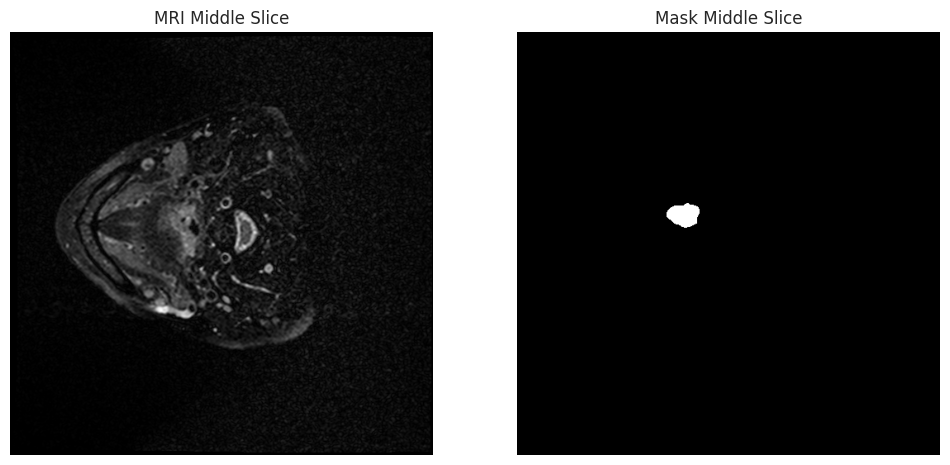

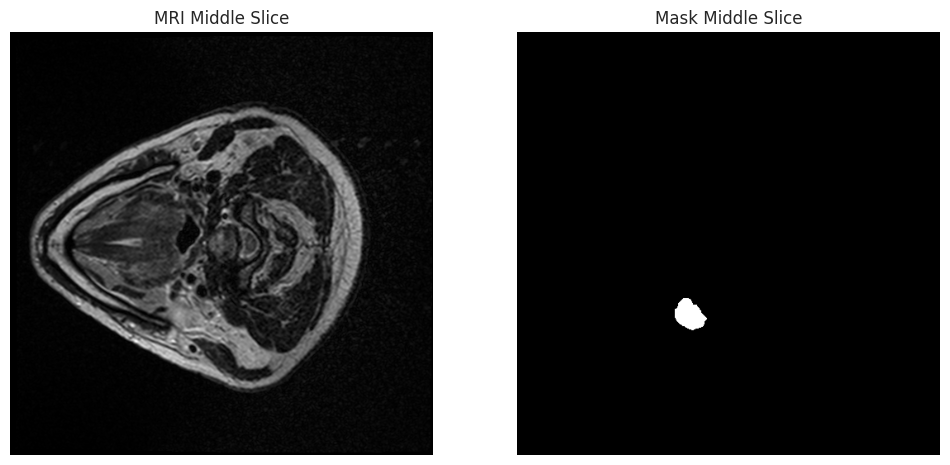

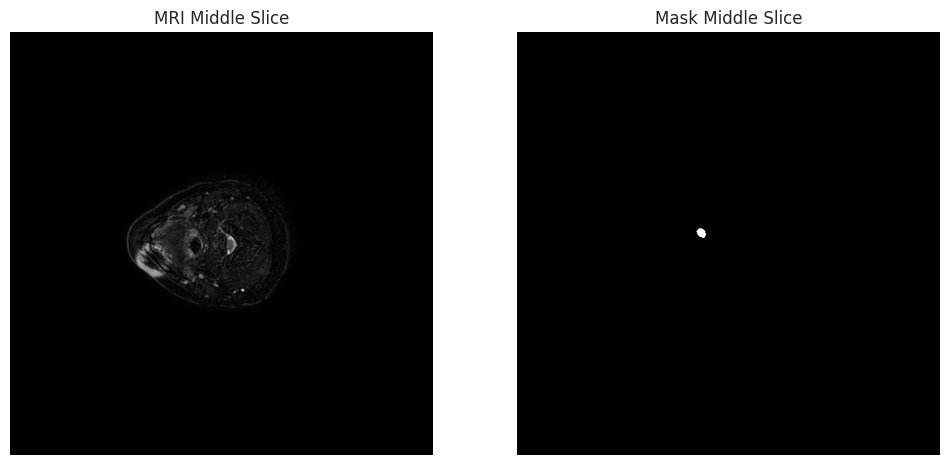

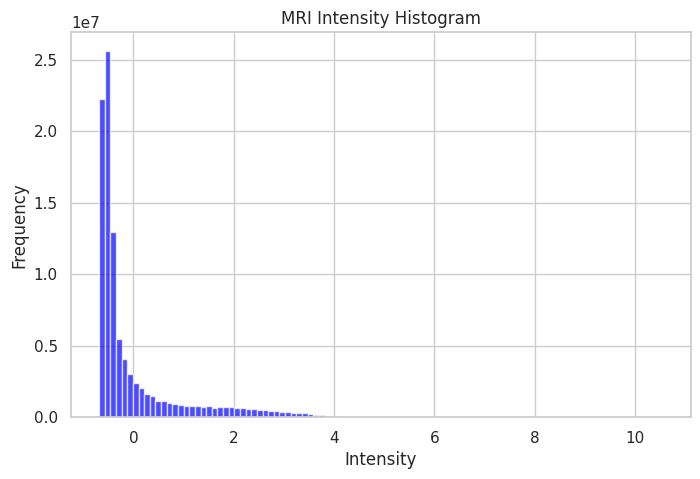

Unique mask values across 10 samples: [np.float32(0.0), np.float32(1.0), np.float32(2.0)]
Sample volume shapes:
torch.Size([512, 512, 75])
torch.Size([512, 512, 76])
torch.Size([512, 512, 82])
torch.Size([512, 512, 73])
torch.Size([512, 512, 74])
torch.Size([512, 512, 77])
torch.Size([512, 512, 75])
torch.Size([512, 512, 73])
torch.Size([528, 528, 133])
torch.Size([528, 528, 129])


In [ ]:
def visualize_random_sample(dataset):
    idx = random.randint(0, len(dataset) - 1)
    mri_tensor, mask_tensor = dataset[idx]

    mri_np = mri_tensor.squeeze(0).numpy()
    mask_np = mask_tensor.squeeze(0).numpy()

    middle_slice_idx = mri_np.shape[2] // 2  # Middle axial slice

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(mri_np[:, :, middle_slice_idx], cmap='gray')
    plt.title('MRI Middle Slice')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np[:, :, middle_slice_idx], cmap='gray')
    plt.title('Mask Middle Slice')
    plt.axis('off')

    plt.show()

# Visualize 3 random samples
for _ in range(3):
    visualize_random_sample(full_dataset)

# ===========================================
# 3. MRI Intensity Histogram
# ===========================================

def plot_intensity_histogram(dataset, num_samples=5):
    all_voxels = []

    for i in range(min(num_samples, len(dataset))):
        mri_tensor, _ = dataset[i]
        mri_np = mri_tensor.squeeze(0).numpy()
        all_voxels.append(mri_np.flatten())

    all_voxels = np.concatenate(all_voxels)

    plt.figure(figsize=(8, 5))
    plt.hist(all_voxels, bins=100, color='blue', alpha=0.7)
    plt.title('MRI Intensity Histogram')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

plot_intensity_histogram(full_dataset)

# ===========================================
# 4. Mask Value Checking (Are masks binary?)
# ===========================================

def check_mask_values(dataset, num_samples=10):
    unique_vals = set()

    for i in range(min(num_samples, len(dataset))):
        _, mask_tensor = dataset[i]
        mask_np = mask_tensor.squeeze(0).numpy()
        unique_vals.update(np.unique(mask_np))

    print(f"Unique mask values across {num_samples} samples: {sorted(unique_vals)}")

check_mask_values(full_dataset)

# ===========================================
# 5. Check Volume Shapes
# ===========================================

def check_volume_shapes(dataset, num_samples=10):
    shapes = []

    for i in range(min(num_samples, len(dataset))):
        mri_tensor, _ = dataset[i]
        shapes.append(mri_tensor.squeeze(0).shape)

    print("Sample volume shapes:")
    for s in shapes:
        print(s)

check_volume_shapes(full_dataset)

Given that the input shapes are different and the variation in MRI intensity we must standardize and normalize both the geometric and intensity characteristics before we can feed this data into our model.

# PreProcessing Pipeline (2-D)

###Create test, train, and validation datasets.

In [ ]:
# Group each patient by their tumor type and split into train, val, and test sets
summary = metadata_df.groupby('patient_folder').agg(
    has_gtvp=('gtvp_volume', lambda x: int(x.sum() > 0)),
    has_gtvn=('gtvn_volume', lambda x: int(x.sum() > 0))
).reset_index()

summary['mask_type'] = summary.apply(
    lambda row: 'both' if row['has_gtvp'] and row['has_gtvn'] else
                'gtvp_only' if row['has_gtvp'] else
                'gtvn_only' if row['has_gtvn'] else
                'empty', axis=1
)

# Perform stratified split by mask_type
train_ids, test_ids = train_test_split(
    summary,
    test_size=0.15,
    stratify=summary['mask_type'],
    random_state=42
)

train_ids, val_ids = train_test_split(
    train_ids,
    test_size=0.176,  # ~15% of total
    stratify=train_ids['mask_type'],
    random_state=42
)

print("Train patients:", len(train_ids))
print("Val patients:", len(val_ids))
print("Test patients:", len(test_ids))


train_patients = train_ids['patient_folder'].tolist()
val_patients = val_ids['patient_folder'].tolist()
test_patients = test_ids['patient_folder'].tolist()

Train patients: 104
Val patients: 23
Test patients: 23


In [ ]:
train_df = metadata_df[metadata_df['patient_folder'].isin(train_patients)]
test_df = metadata_df[metadata_df['patient_folder'].isin(test_patients)]
val_df = metadata_df[metadata_df['patient_folder'].isin(val_patients)]

#let's split our data into training, validation, and test sets

train_df.to_csv('/content/drive/MyDrive/cv_mr_data/data/train_metadata.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/cv_mr_data/data/test_metadata.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/cv_mr_data/data/val_metadata.csv', index=False)

train_df.head()


patient_folder timepoint  \
0              10     preRT   
1              10     midRT   
2             101     preRT   
3             101     midRT   
4             103     preRT   

                                           scan_path  \
0  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
1  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
2  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
3  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   
4  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...   

                                           mask_path  tumor_volume  \
0  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         26867   
1  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         25215   
2  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         25550   
3  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         13638   
4  /content/drive/MyDrive/cv_mr_data/data/HNTSMRG...         45298   

   gtvp_volume  gtvn_volume  
0         8009        18858  
1         1490        23725  
2         3051        22499  
3            0        13638  
4         8277        37021

In [ ]:
#print column names of train_df
print(train_df.columns)

Index(['patient_folder', 'timepoint', 'scan_path', 'mask_path', 'tumor_volume',
       'gtvp_volume', 'gtvn_volume'],
      dtype='object')


### Extract 2D Slices from the 3D MRI and mask and also

In [ ]:
train_df=pd.read_csv('/content/drive/MyDrive/cv_mr_data/data/train_metadata.csv')
test_df=pd.read_csv('/content/drive/MyDrive/cv_mr_data/data/test_metadata.csv')
val_df=pd.read_csv('/content/drive/MyDrive/cv_mr_data/data/val_metadata.csv')

In [ ]:
#Normalize pixel intensity, and extract and resize slices to create a 2D dataset
import os
import torch
import nibabel as nib
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

def save_slices_from_metadata(metadata_csv, save_dir, resize_to=(256, 256), normalize=True):
    df = pd.read_csv(metadata_csv)
    os.makedirs(save_dir, exist_ok=True)
    slice_id = 0

    for _, row in tqdm(df.iterrows(), total=len(df)):
        patient_id = row['patient_folder']
        timepoint = row['timepoint']
        scan_path = row['scan_path']
        mask_path = row['mask_path']

        if pd.isna(scan_path) or pd.isna(mask_path):
            continue

        try:
            mri = nib.load(scan_path).get_fdata()
            mask = nib.load(mask_path).get_fdata()
        except Exception as e:
            print(f"Failed to load for patient {patient_id} ({timepoint}): {e}")
            continue

        if normalize:
            mean = np.mean(mri)
            std = np.std(mri) + 1e-8
            mri = (mri - mean) / std

        num_slices = mri.shape[2]

        for i in range(num_slices):
            mri_slice = mri[:, :, i]
            mask_slice = mask[:, :, i]

            mri_resized = cv2.resize(mri_slice, resize_to, interpolation=cv2.INTER_LINEAR)
            #mask_resized = cv2.resize(mask_slice, resize_to, interpolation=cv2.INTER_NEAREST)

            mri_tensor = torch.tensor(mri_resized, dtype=torch.float32).unsqueeze(0)
            #mask_tensor = torch.tensor(mask_resized, dtype=torch.long)

            save_path = os.path.join(save_dir, f"{patient_id}_{timepoint}_slice{i:03d}.pt")

            torch.save({
                'mri': mri_tensor,
                'mask': mask_tensor,
                'meta': {
                    'patient_id': int(patient_id),
                    'timepoint': timepoint,
                    'slice_idx': i
                }
            }, save_path)

            slice_id += 1

    print(f"Saved {slice_id} slices to {save_dir}")

In [ ]:
#save the mri_slices and mask_slices
save_slices_from_metadata('/content/drive/MyDrive/cv_mr_data/data/train_metadata.csv', '/content/drive/MyDrive/cv_mr_data/data/train_slices')
save_slices_from_metadata('/content/drive/MyDrive/cv_mr_data/data/test_metadata.csv', '/content/drive/MyDrive/cv_mr_data/data/test_slices')
save_slices_from_metadata('/content/drive/MyDrive/cv_mr_data/data/val_metadata.csv', '/content/drive/MyDrive/cv_mr_data/data/val_slices')

100%|██████████| 208/208 [14:09<00:00,  4.08s/it]



✅ Saved 17608 slices to /content/drive/MyDrive/cv_mr_data/data/train_slices


100%|██████████| 46/46 [03:12<00:00,  4.19s/it]



✅ Saved 4161 slices to /content/drive/MyDrive/cv_mr_data/data/test_slices


100%|██████████| 46/46 [03:10<00:00,  4.15s/it]


✅ Saved 3839 slices to /content/drive/MyDrive/cv_mr_data/data/val_slices



🧾 Sample 0:
  MRI shape: torch.Size([1, 256, 256])  | dtype: torch.float32
  Mask shape: torch.Size([256, 256])  | dtype: torch.int64
  MRI mean: -0.104, std: 0.843
  Mask values: [0]

🧾 Sample 1:
  MRI shape: torch.Size([1, 256, 256])  | dtype: torch.float32
  Mask shape: torch.Size([256, 256])  | dtype: torch.int64
  MRI mean: -0.025, std: 0.868
  Mask values: [0]

🧾 Sample 2:
  MRI shape: torch.Size([1, 256, 256])  | dtype: torch.float32
  Mask shape: torch.Size([256, 256])  | dtype: torch.int64
  MRI mean: -0.014, std: 0.844
  Mask values: [0]

🧾 Sample 3:
  MRI shape: torch.Size([1, 256, 256])  | dtype: torch.float32
  Mask shape: torch.Size([256, 256])  | dtype: torch.int64
  MRI mean: -0.022, std: 0.829
  Mask values: [0]

🧾 Sample 4:
  MRI shape: torch.Size([1, 256, 256])  | dtype: torch.float32
  Mask shape: torch.Size([256, 256])  | dtype: torch.int64
  MRI mean: -0.034, std: 0.821
  Mask values: [0]
🔍 Visualizing sample 0


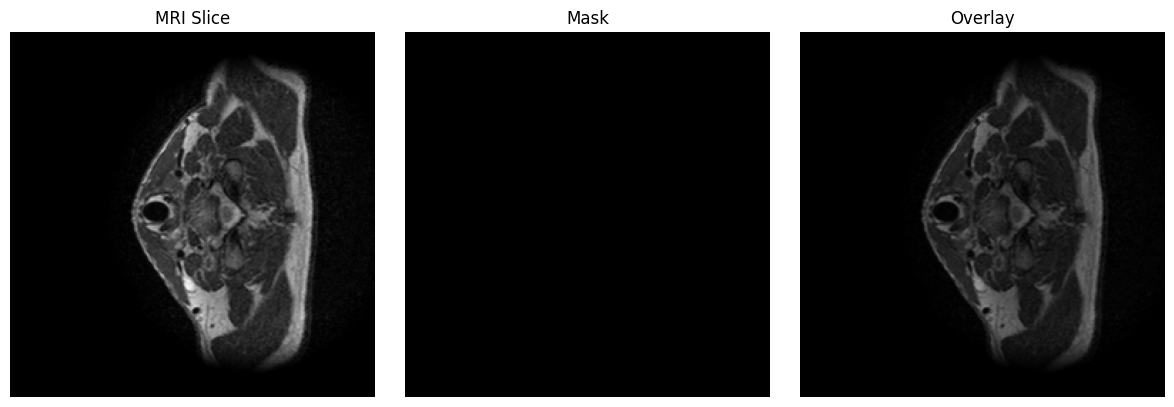

🔍 Visualizing sample 1


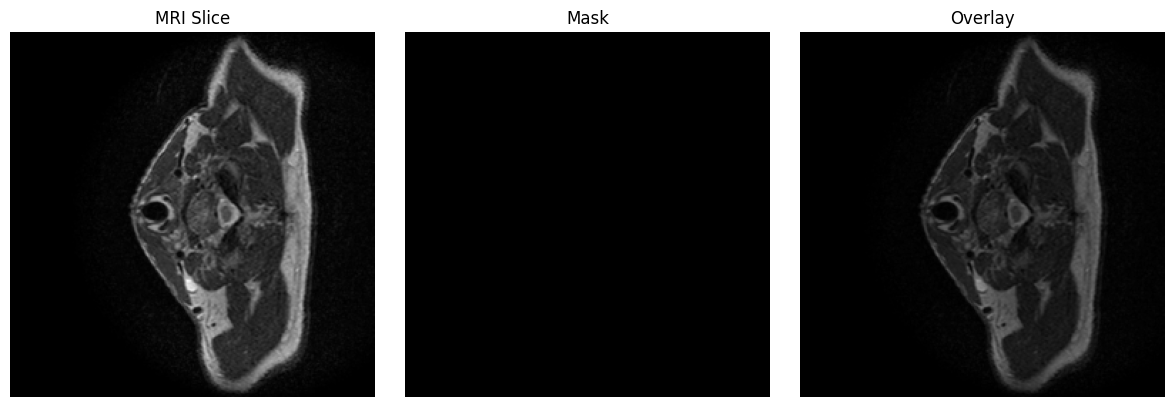

🔍 Visualizing sample 2


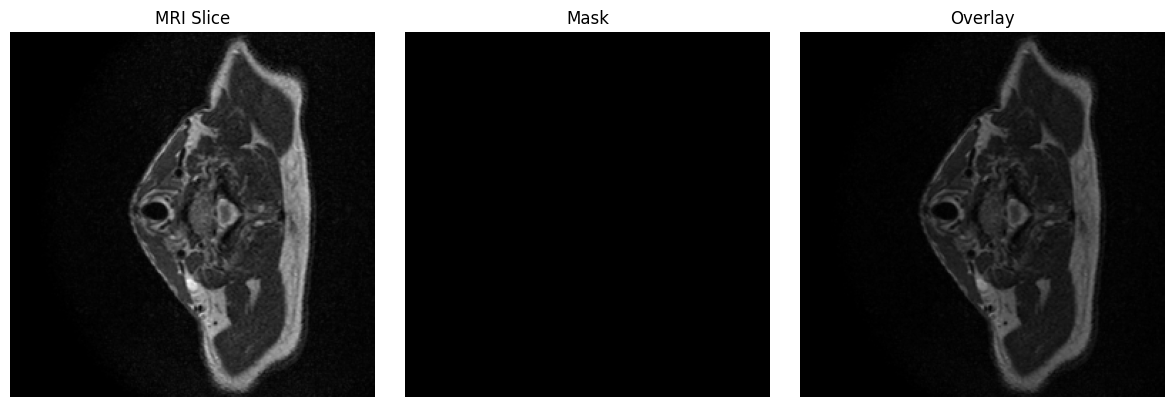

🔍 Visualizing sample 3


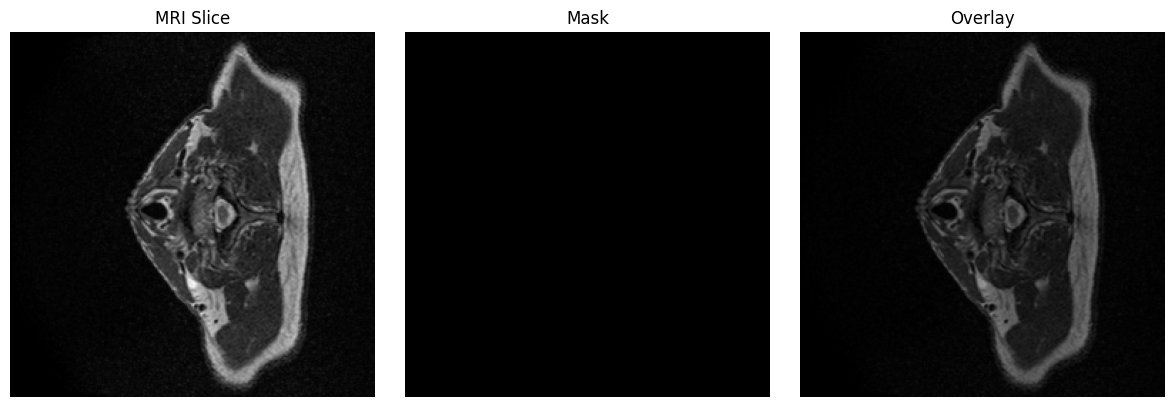

🔍 Visualizing sample 4


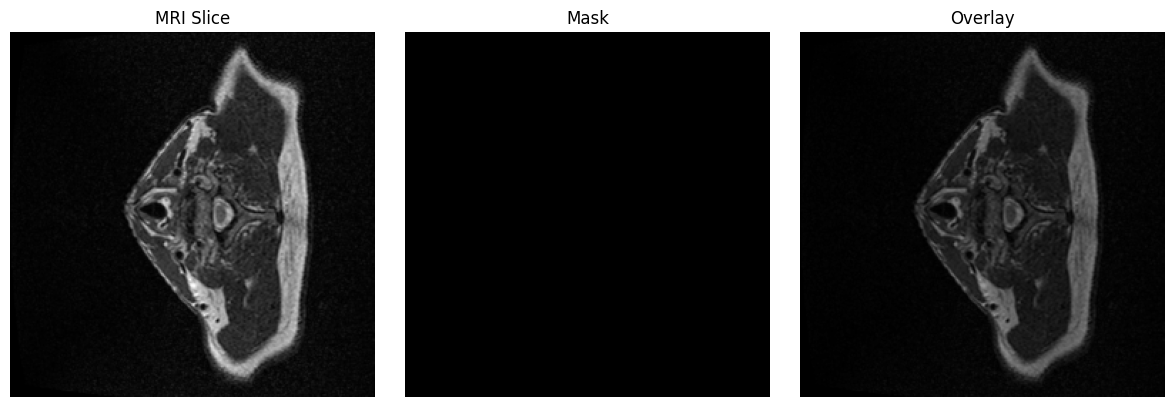

In [ ]:
#check the shape and intensity range of the mri_slices and mask_slices
def load_sample_slices(folder, num_samples=5):
    files = sorted([f for f in os.listdir(folder) if f.endswith('.pt')])
    sample_files = files[:num_samples]
    samples = [torch.load(os.path.join(folder, f)) for f in sample_files]
    return samples

def check_shapes_and_stats(samples):
    for i, sample in enumerate(samples):
        mri = sample['mri']
        mask = sample['mask']

        print(f"\n🧾 Sample {i}:")
        print(f"  MRI shape: {mri.shape}  | dtype: {mri.dtype}")
        print(f"  Mask shape: {mask.shape}  | dtype: {mask.dtype}")
        print(f"  MRI mean: {mri.mean().item():.3f}, std: {mri.std().item():.3f}")
        print(f"  Mask values: {torch.unique(mask).tolist()}")

def visualize_sample(sample, figsize=(12, 4)):
    mri = sample['mri'].squeeze(0).numpy()
    mask = sample['mask'].numpy()

    plt.figure(figsize=figsize)

    plt.subplot(1, 3, 1)
    plt.imshow(mri, cmap='gray')
    plt.title('MRI Slice')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title('Mask')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(mri, cmap='gray')
    plt.imshow(mask, cmap='gray', alpha=0.4)
    plt.title('Overlay')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

samples = load_sample_slices('/content/drive/MyDrive/cv_mr_data/data/train_slices')
check_shapes_and_stats(samples)
for i, sample in enumerate(samples[:10]):
    print(f"🔍 Visualizing sample {i}")
    visualize_sample(sample)

In [ ]:
from collections import Counter
def summarize_slice_folder(slice_folder):
    summary = {
        'total_slices': 0,
        'empty': 0,
        'gtvp_only': 0,
        'gtvn_only': 0,
        'both': 0
    }

    pixel_counts = torch.zeros(3, dtype=torch.long)

    files = [f for f in os.listdir(slice_folder) if f.endswith('.pt')]

    for f in files:
        data = torch.load(os.path.join(slice_folder, f))
        mask = data['mask']
        unique_vals = torch.unique(mask).tolist()

        summary['total_slices'] += 1

        if unique_vals == [0]:
            summary['empty'] += 1
        elif set(unique_vals) == {0, 1}:
            summary['gtvp_only'] += 1
        elif set(unique_vals) == {0, 2}:
            summary['gtvn_only'] += 1
        elif 1 in unique_vals and 2 in unique_vals:
            summary['both'] += 1

        pixel_counts += torch.bincount(mask.flatten(), minlength=3)

    print(f"\n Summary for: {os.path.basename(slice_folder)}")
    print(f"Total slices: {summary['total_slices']}")
    print(f"  Empty:       {summary['empty']}")
    print(f"  GTVp only:   {summary['gtvp_only']}")
    print(f"  GTVn only:   {summary['gtvn_only']}")
    print(f"  Both:        {summary['both']}")

    print("\n Pixel counts (summed over all slices):")
    for i in range(3):
        print(f"  Class {i}: {pixel_counts[i].item():,} pixels")

    return summary, pixel_counts

In [ ]:
train_slices='/content/drive/MyDrive/cv_mr_data/data/train_slices'
test_slices='/content/drive/MyDrive/cv_mr_data/data/test_slices'
val_slices='/content/drive/MyDrive/cv_mr_data/data/val_slices'


In [ ]:
train_summary, train_class_pixel_counts = summarize_slice_folder(train_slices)
print("\n Summary for train_slices:")
print("Slice distribution:", train_summary)
print("Class pixel counts:", {i: int(train_class_pixel_counts[i]) for i in range(len(train_class_pixel_counts))})

val_summary, val_class_pixel_counts = summarize_slice_folder(val_slices)
print("\n Summary for val_slices:")
print("Slice distribution:", val_summary)
print("Class pixel counts:", {i: int(val_class_pixel_counts[i]) for i in range(len(val_class_pixel_counts))})

test_summary, test_class_pixel_counts = summarize_slice_folder(test_slices)
print("\n Summary for test_slices:")
print("Slice distribution:", test_summary)
print("Class pixel counts:", {i: int(test_class_pixel_counts[i]) for i in range(len(test_class_pixel_counts))})



 Summary for: train_slices
Total slices: 17608
  Empty:       10892
  GTVp only:   1692
  GTVn only:   3642
  Both:        1382

 Pixel counts (summed over all slices):
  Class 0: 1,152,221,376 pixels
  Class 1: 650,309 pixels
  Class 2: 1,086,203 pixels

 Summary for train_slices:
Slice distribution: {'total_slices': 17608, 'empty': 10892, 'gtvp_only': 1692, 'gtvn_only': 3642, 'both': 1382}
Class pixel counts: {0: 1152221376, 1: 650309, 2: 1086203}

 Summary for: val_slices
Total slices: 3839
  Empty:       2625
  GTVp only:   288
  GTVn only:   647
  Both:        279

 Pixel counts (summed over all slices):
  Class 0: 251,268,754 pixels
  Class 1: 147,649 pixels
  Class 2: 176,301 pixels

 Summary for val_slices:
Slice distribution: {'total_slices': 3839, 'empty': 2625, 'gtvp_only': 288, 'gtvn_only': 647, 'both': 279}
Class pixel counts: {0: 251268754, 1: 147649, 2: 176301}

 Summary for: test_slices
Total slices: 4161
  Empty:       2771
  GTVp only:   371
  GTVn only:   689
  Both

#3. Pipeline for Final Datasets for our Models
Using Dataloader build final dataset for our train, validation and test data using the extracted and preprocessed 2-D slices


In [ ]:
class SliceDataset(Dataset):
    def __init__(self, slice_dir):
        self.slice_dir = slice_dir
        self.files = sorted([
            os.path.join(slice_dir, f)
            for f in os.listdir(slice_dir) if f.endswith('.pt')
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        mri = data['mri']          # shape (1, H, W)
        mask = data['mask']        # shape (H, W)
        return mri, mask

def get_dataloader(slice_dir, batch_size=8, shuffle=True, num_workers=2, prefetch_factor=2):
    dataset = SliceDataset(slice_dir)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        prefetch_factor=prefetch_factor,
        pin_memory=True  # Speeds up GPU transfer
    )
    return dataloader

train_loader = get_dataloader('/content/drive/MyDrive/cv_mr_data/data/train_slices', batch_size=8, shuffle=True)
val_loader   = get_dataloader('/content/drive/MyDrive/cv_mr_data/data/val_slices', batch_size=8, shuffle=False)
test_loader  = get_dataloader('/content/drive/MyDrive/cv_mr_data/data/test_slices', batch_size=8, shuffle=False)

for mri_batch, mask_batch in train_loader:
    print("MRI batch:", mri_batch.shape)   # [B, 1, H, W]
    print("Mask batch:", mask_batch.shape) # [B, H, W]
    break

MRI batch: torch.Size([8, 1, 256, 256])
Mask batch: torch.Size([8, 256, 256])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("📟 Using device:", device)

📟 Using device: cuda


###Cross Entropy Custom Loss Function for Class Imbalance

In [ ]:
def compute_class_weights(pixel_counts, normalize=True):
    weights = 1.0 / (pixel_counts.float() + 1e-8)
    if normalize:
        weights = weights / weights.sum()
    return weights

class WeightedSegmentationLoss(nn.Module):
    def __init__(self, class_weights):
        super().__init__()
        self.ce_loss = nn.CrossEntropyLoss(weight=class_weights)

    def forward(self, preds, targets):
        """
        preds: [B, C, H, W] logits
        targets: [B, H, W] ground-truth labels
        """
        return self.ce_loss(preds, targets)

class_weights = compute_class_weights(train_class_pixel_counts)
print("Class weights:", class_weights)

Class weights: tensor([4.3654e-04, 5.8848e-01, 4.1109e-01])


### Other Loss Functions; DICE, Focal, and Custom Loss Functions

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets, num_classes=3):
        preds = F.softmax(preds, dim=1)                     # [B, C, H, W]
        targets_onehot = F.one_hot(targets, num_classes)    # [B, H, W, C]
        targets_onehot = targets_onehot.permute(0, 3, 1, 2).float()  # [B, C, H, W]

        intersection = (preds * targets_onehot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_onehot.sum(dim=(2, 3))

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score.mean()

class CombinedLoss(nn.Module):
    def __init__(self, class_weights, dice_weight=0.5):
        super().__init__()
        self.ce = nn.CrossEntropyLoss(weight=class_weights)
        self.dice = DiceLoss()
        self.alpha = dice_weight

    def forward(self, preds, targets):
        ce = self.ce(preds, targets)
        dice = self.dice(preds, targets)
        return self.alpha * dice + (1 - self.alpha) * ce

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None):
        super().__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight)

    def forward(self, logits, target):
        logp = F.log_softmax(logits, dim=1)
        p = torch.exp(logp)
        focal_term = (1 - p) ** self.gamma
        loss = focal_term * logp
        return F.nll_loss(loss, target, weight=self.ce.weight)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# class weights on GPU
class_weights = compute_class_weights(train_class_pixel_counts).to(device)

# CrossEntropy only
ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

# Dice only
dice_loss_fn = DiceLoss().to(device)

# Combined CE + Dice
combined_loss_fn = CombinedLoss(class_weights, dice_weight=0.5).to(device)

# Focal loss
focal_loss_fn = FocalLoss(gamma=2, weight=class_weights).to(device)

### Training and Evaluation Pipelines

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    loss_fn,
    optimizer,
    num_epochs,
    save_dir,
    device='cuda',
    scheduler=None,
    early_stopping_patience=5
):
    model = model.to(device)
    os.makedirs(save_dir, exist_ok=True)

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_dice': []
    }

    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = os.path.join(save_dir, f"{model_name}_best.pt")

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0.0

        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            preds = model(x)
            loss = loss_fn(preds, y)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_loader)
        history['train_loss'].append(train_loss)

        # Validation
        val_metrics = evaluate_model(model, val_loader, loss_fn, device=device)
        val_loss = val_metrics["loss"]
        val_dice = val_metrics["dice"]

        history['val_loss'].append(val_loss)
        history['val_dice'].append(val_dice)

        # Epoch Summary
        print(f" Epoch {epoch+1}")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}")
        print(f"  Val Dice:   {val_dice:.4f}")

        #Scheduler step (ReduceLROnPlateau)
        if scheduler:
            scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model to {best_model_path}")
        else:
            patience_counter += 1
            print(f"No improvement. Patience counter: {patience_counter}/{early_stopping_patience}")

            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered.")
                break

    #Save training history
    history_path = os.path.join(save_dir, 'training_history.json')
    with open(history_path, 'w') as f:
        json.dump(history, f, indent=2)
    print(f"\Training history saved to {history_path}")

    return model, history

In [ ]:
def evaluate_model(model, dataloader, loss_fn=None, device='cuda', num_classes=3):
    model.eval()
    total_loss = 0
    pixel_preds = []
    pixel_targets = []

    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)
            y = y.to(device)

            preds = model(x)
            if loss_fn:
                total_loss += loss_fn(preds, y).item()

            probs = torch.softmax(preds, dim=1)
            preds_cls = torch.argmax(probs, dim=1)

            pixel_preds.append(preds_cls.cpu().numpy().flatten())
            pixel_targets.append(y.cpu().numpy().flatten())

    y_true = np.concatenate(pixel_targets)
    y_pred = np.concatenate(pixel_preds)

    # Per-class metrics
    from sklearn.metrics import precision_score, recall_score, jaccard_score, f1_score
    class_names = ["Background", "GTVp", "GTVn"]
    precisions = precision_score(y_true, y_pred, average=None, labels=range(num_classes), zero_division=0)
    recalls = recall_score(y_true, y_pred, average=None, labels=range(num_classes), zero_division=0)
    ious = jaccard_score(y_true, y_pred, average=None, labels=range(num_classes), zero_division=0)
    f1s = f1_score(y_true, y_pred, average=None, labels=range(num_classes), zero_division=0)

    # Inline Dice calculation
    dice_scores = []
    for c in range(num_classes):
        pred_mask = (y_pred == c).astype(np.uint8)
        true_mask = (y_true == c).astype(np.uint8)
        intersection = (pred_mask & true_mask).sum()
        union = pred_mask.sum() + true_mask.sum()
        dice = (2 * intersection + 1e-6) / (union + 1e-6)
        dice_scores.append(dice)

    print("\ Evaluation Metrics (Per Class):")
    for c in range(num_classes):
        print(f"  Class {c} ({class_names[c]}):")
        print(f"    Dice:     {dice_scores[c]:.4f}")
        print(f"    IoU:      {ious[c]:.4f}")
        print(f"    Precision:{precisions[c]:.4f}")
        print(f"    Recall:   {recalls[c]:.4f}")
        print(f"    F1 Score: {f1s[c]:.4f}")

    metrics = {
        "loss": total_loss / len(dataloader) if loss_fn else None,
        "dice": np.mean(dice_scores[1:]),  # exclude background
        "iou": np.mean(ious[1:]),
        "precision": np.mean(precisions[1:]),
        "recall": np.mean(recalls[1:])
    }

    return metrics

# Baseline Model: U-Net

In [ ]:
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super().__init__()
        # Encoder
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bottleneck
        self.bottleneck = self.conv_block(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.conv_block(1024, 512)
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.conv_block(512, 256)
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoding path
        d4 = self.upconv4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)  # logits


In [ ]:
model_name='unet_model_ce_loss'
unet_model_ce_loss = UNet(in_channels=1, num_classes=3).to(device)

optimizer = torch.optim.Adam(unet_model_ce_loss.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_model, history = train_model(
    model=unet_model_ce_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=ce_loss_fn,
    optimizer=optimizer,
    num_epochs=50,
    scheduler=scheduler,
    save_dir='/content/drive/MyDrive/cv_mr_data/models',
    device=device,
    early_stopping_patience=7
)

Epoch 1/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9800
    IoU:      0.9608
    Precision:1.0000
    Recall:   0.9609
    F1 Score: 0.9800
  Class 1 (GTVp):
    Dice:     0.0608
    IoU:      0.0314
    Precision:0.0314
    Recall:   0.9362
    F1 Score: 0.0608
  Class 2 (GTVn):
    Dice:     0.0563
    IoU:      0.0289
    Precision:0.0290
    Recall:   0.9457
    F1 Score: 0.0563
 Epoch 1
  Train Loss: 0.2654
  Val Loss:   0.1420
  Val Dice:   0.0585
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unet_model_ce_loss_best.pt


Epoch 2/50 - Training: 100%|██████████| 2201/2201 [02:11<00:00, 16.80it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9821
    IoU:      0.9649
    Precision:1.0000
    Recall:   0.9649
    F1 Score: 0.9821
  Class 1 (GTVp):
    Dice:     0.0511
    IoU:      0.0262
    Precision:0.0262
    Recall:   0.9895
    F1 Score: 0.0511
  Class 2 (GTVn):
    Dice:     0.0908
    IoU:      0.0476
    Precision:0.0477
    Recall:   0.9613
    F1 Score: 0.0908
 Epoch 2
  Train Loss: 0.0848
  Val Loss:   0.0992
  Val Dice:   0.0709
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unet_model_ce_loss_best.pt


Epoch 3/50 - Training: 100%|██████████| 2201/2201 [02:11<00:00, 16.77it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9770
    IoU:      0.9550
    Precision:1.0000
    Recall:   0.9551
    F1 Score: 0.9770
  Class 1 (GTVp):
    Dice:     0.0455
    IoU:      0.0233
    Precision:0.0233
    Recall:   0.9875
    F1 Score: 0.0455
  Class 2 (GTVn):
    Dice:     0.0612
    IoU:      0.0316
    Precision:0.0316
    Recall:   0.9581
    F1 Score: 0.0612
 Epoch 3
  Train Loss: 0.0757
  Val Loss:   0.1114
  Val Dice:   0.0533
No improvement. Patience counter: 1/7


Epoch 4/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9742
    IoU:      0.9498
    Precision:1.0000
    Recall:   0.9498
    F1 Score: 0.9742
  Class 1 (GTVp):
    Dice:     0.0673
    IoU:      0.0348
    Precision:0.0349
    Recall:   0.9762
    F1 Score: 0.0673
  Class 2 (GTVn):
    Dice:     0.0384
    IoU:      0.0196
    Precision:0.0196
    Recall:   0.9786
    F1 Score: 0.0384
 Epoch 4
  Train Loss: 0.0589
  Val Loss:   0.1128
  Val Dice:   0.0529
No improvement. Patience counter: 2/7


Epoch 5/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9781
    IoU:      0.9571
    Precision:1.0000
    Recall:   0.9571
    F1 Score: 0.9781
  Class 1 (GTVp):
    Dice:     0.0748
    IoU:      0.0389
    Precision:0.0390
    Recall:   0.9305
    F1 Score: 0.0748
  Class 2 (GTVn):
    Dice:     0.0447
    IoU:      0.0229
    Precision:0.0229
    Recall:   0.9833
    F1 Score: 0.0447
 Epoch 5
  Train Loss: 0.0475
  Val Loss:   0.1329
  Val Dice:   0.0598
No improvement. Patience counter: 3/7


Epoch 6/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9892
    IoU:      0.9786
    Precision:1.0000
    Recall:   0.9786
    F1 Score: 0.9892
  Class 1 (GTVp):
    Dice:     0.0862
    IoU:      0.0450
    Precision:0.0450
    Recall:   0.9849
    F1 Score: 0.0862
  Class 2 (GTVn):
    Dice:     0.1294
    IoU:      0.0692
    Precision:0.0693
    Recall:   0.9685
    F1 Score: 0.1294
 Epoch 6
  Train Loss: 0.0410
  Val Loss:   0.0779
  Val Dice:   0.1078
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unet_model_ce_loss_best.pt


Epoch 7/50 - Training: 100%|██████████| 2201/2201 [02:11<00:00, 16.80it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9913
    IoU:      0.9827
    Precision:1.0000
    Recall:   0.9828
    F1 Score: 0.9913
  Class 1 (GTVp):
    Dice:     0.0953
    IoU:      0.0500
    Precision:0.0501
    Recall:   0.9788
    F1 Score: 0.0953
  Class 2 (GTVn):
    Dice:     0.1737
    IoU:      0.0951
    Precision:0.0956
    Recall:   0.9530
    F1 Score: 0.1737
 Epoch 7
  Train Loss: 0.0399
  Val Loss:   0.0817
  Val Dice:   0.1345
No improvement. Patience counter: 1/7


Epoch 8/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.09it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9920
    IoU:      0.9841
    Precision:0.9999
    Recall:   0.9842
    F1 Score: 0.9920
  Class 1 (GTVp):
    Dice:     0.1122
    IoU:      0.0594
    Precision:0.0596
    Recall:   0.9450
    F1 Score: 0.1122
  Class 2 (GTVn):
    Dice:     0.1568
    IoU:      0.0851
    Precision:0.0855
    Recall:   0.9428
    F1 Score: 0.1568
 Epoch 8
  Train Loss: 0.0385
  Val Loss:   0.1406
  Val Dice:   0.1345
No improvement. Patience counter: 2/7


Epoch 9/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9839
    IoU:      0.9684
    Precision:1.0000
    Recall:   0.9684
    F1 Score: 0.9839
  Class 1 (GTVp):
    Dice:     0.0457
    IoU:      0.0234
    Precision:0.0234
    Recall:   0.9809
    F1 Score: 0.0457
  Class 2 (GTVn):
    Dice:     0.1500
    IoU:      0.0811
    Precision:0.0814
    Recall:   0.9550
    F1 Score: 0.1500
 Epoch 9
  Train Loss: 0.0349
  Val Loss:   0.1049
  Val Dice:   0.0979
No improvement. Patience counter: 3/7


Epoch 10/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9919
    IoU:      0.9838
    Precision:1.0000
    Recall:   0.9839
    F1 Score: 0.9919
  Class 1 (GTVp):
    Dice:     0.1073
    IoU:      0.0567
    Precision:0.0568
    Recall:   0.9691
    F1 Score: 0.1073
  Class 2 (GTVn):
    Dice:     0.1678
    IoU:      0.0916
    Precision:0.0919
    Recall:   0.9640
    F1 Score: 0.1678
 Epoch 10
  Train Loss: 0.0283
  Val Loss:   0.0954
  Val Dice:   0.1376
No improvement. Patience counter: 4/7


Epoch 11/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.09it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9936
    IoU:      0.9873
    Precision:0.9999
    Recall:   0.9874
    F1 Score: 0.9936
  Class 1 (GTVp):
    Dice:     0.1426
    IoU:      0.0768
    Precision:0.0770
    Recall:   0.9613
    F1 Score: 0.1426
  Class 2 (GTVn):
    Dice:     0.1842
    IoU:      0.1014
    Precision:0.1020
    Recall:   0.9506
    F1 Score: 0.1842
 Epoch 11
  Train Loss: 0.0212
  Val Loss:   0.1118
  Val Dice:   0.1634
No improvement. Patience counter: 5/7


Epoch 12/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.09it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9944
    IoU:      0.9889
    Precision:0.9999
    Recall:   0.9890
    F1 Score: 0.9944
  Class 1 (GTVp):
    Dice:     0.1462
    IoU:      0.0789
    Precision:0.0791
    Recall:   0.9668
    F1 Score: 0.1462
  Class 2 (GTVn):
    Dice:     0.2310
    IoU:      0.1306
    Precision:0.1314
    Recall:   0.9520
    F1 Score: 0.2310
 Epoch 12
  Train Loss: 0.0223
  Val Loss:   0.1078
  Val Dice:   0.1886
No improvement. Patience counter: 6/7


Epoch 13/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9950
    IoU:      0.9900
    Precision:0.9999
    Recall:   0.9901
    F1 Score: 0.9950
  Class 1 (GTVp):
    Dice:     0.1506
    IoU:      0.0814
    Precision:0.0820
    Recall:   0.9164
    F1 Score: 0.1506
  Class 2 (GTVn):
    Dice:     0.2545
    IoU:      0.1458
    Precision:0.1468
    Recall:   0.9546
    F1 Score: 0.2545
 Epoch 13
  Train Loss: 0.0180
  Val Loss:   0.1194
  Val Dice:   0.2025
No improvement. Patience counter: 7/7
Early stopping triggered.
\Training history saved to /content/drive/MyDrive/cv_mr_data/models/training_history.json


In [ ]:
model_name = 'unet_model_combined_loss'
unet_model_combined_loss = UNet(in_channels=1, num_classes=3).to(device)

optimizer = torch.optim.Adam(unet_model_combined_loss.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_model, history = train_model(
    model=unet_model_combined_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=combined_loss_fn,
    optimizer=optimizer,
    num_epochs=50,
    scheduler=scheduler,
    save_dir='/content/drive/MyDrive/cv_mr_data/models',
    device=device,
    early_stopping_patience=7
)

Epoch 1/50 - Training: 100%|██████████| 2201/2201 [02:10<00:00, 16.90it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9887
    IoU:      0.9777
    Precision:0.9999
    Recall:   0.9778
    F1 Score: 0.9887
  Class 1 (GTVp):
    Dice:     0.1137
    IoU:      0.0603
    Precision:0.0604
    Recall:   0.9741
    F1 Score: 0.1137
  Class 2 (GTVn):
    Dice:     0.0903
    IoU:      0.0473
    Precision:0.0474
    Recall:   0.9448
    F1 Score: 0.0903
 Epoch 1
  Train Loss: 0.4546
  Val Loss:   0.3726
  Val Dice:   0.1020
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unet_model_combined_loss_best.pt


Epoch 2/50 - Training: 100%|██████████| 2201/2201 [02:10<00:00, 16.84it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9867
    IoU:      0.9738
    Precision:0.9999
    Recall:   0.9739
    F1 Score: 0.9867
  Class 1 (GTVp):
    Dice:     0.0712
    IoU:      0.0369
    Precision:0.0370
    Recall:   0.9556
    F1 Score: 0.0712
  Class 2 (GTVn):
    Dice:     0.1036
    IoU:      0.0547
    Precision:0.0548
    Recall:   0.9487
    F1 Score: 0.1036
 Epoch 2
  Train Loss: 0.3625
  Val Loss:   0.3840
  Val Dice:   0.0874
No improvement. Patience counter: 1/7


Epoch 3/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.13it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9886
    IoU:      0.9775
    Precision:1.0000
    Recall:   0.9776
    F1 Score: 0.9886
  Class 1 (GTVp):
    Dice:     0.0753
    IoU:      0.0391
    Precision:0.0391
    Recall:   0.9843
    F1 Score: 0.0753
  Class 2 (GTVn):
    Dice:     0.1398
    IoU:      0.0751
    Precision:0.0754
    Recall:   0.9574
    F1 Score: 0.1398
 Epoch 3
  Train Loss: 0.3454
  Val Loss:   0.3418
  Val Dice:   0.1075
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unet_model_combined_loss_best.pt


Epoch 4/50 - Training: 100%|██████████| 2201/2201 [02:10<00:00, 16.82it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9912
    IoU:      0.9825
    Precision:0.9999
    Recall:   0.9826
    F1 Score: 0.9912
  Class 1 (GTVp):
    Dice:     0.1392
    IoU:      0.0748
    Precision:0.0754
    Recall:   0.9099
    F1 Score: 0.1392
  Class 2 (GTVn):
    Dice:     0.1066
    IoU:      0.0563
    Precision:0.0565
    Recall:   0.9300
    F1 Score: 0.1066
 Epoch 4
  Train Loss: 0.2875
  Val Loss:   0.3224
  Val Dice:   0.1229
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unet_model_combined_loss_best.pt


Epoch 5/50 - Training: 100%|██████████| 2201/2201 [02:10<00:00, 16.81it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9902
    IoU:      0.9806
    Precision:0.9999
    Recall:   0.9807
    F1 Score: 0.9902
  Class 1 (GTVp):
    Dice:     0.1271
    IoU:      0.0679
    Precision:0.0681
    Recall:   0.9530
    F1 Score: 0.1271
  Class 2 (GTVn):
    Dice:     0.1016
    IoU:      0.0535
    Precision:0.0537
    Recall:   0.9424
    F1 Score: 0.1016
 Epoch 5
  Train Loss: 0.2495
  Val Loss:   0.3200
  Val Dice:   0.1143
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unet_model_combined_loss_best.pt


Epoch 6/50 - Training: 100%|██████████| 2201/2201 [02:10<00:00, 16.83it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9928
    IoU:      0.9858
    Precision:0.9999
    Recall:   0.9859
    F1 Score: 0.9928
  Class 1 (GTVp):
    Dice:     0.1260
    IoU:      0.0673
    Precision:0.0675
    Recall:   0.9588
    F1 Score: 0.1260
  Class 2 (GTVn):
    Dice:     0.1656
    IoU:      0.0902
    Precision:0.0911
    Recall:   0.9086
    F1 Score: 0.1656
 Epoch 6
  Train Loss: 0.2308
  Val Loss:   0.3326
  Val Dice:   0.1458
No improvement. Patience counter: 1/7


Epoch 7/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.12it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9931
    IoU:      0.9863
    Precision:0.9999
    Recall:   0.9864
    F1 Score: 0.9931
  Class 1 (GTVp):
    Dice:     0.1269
    IoU:      0.0678
    Precision:0.0680
    Recall:   0.9594
    F1 Score: 0.1269
  Class 2 (GTVn):
    Dice:     0.1715
    IoU:      0.0938
    Precision:0.0951
    Recall:   0.8776
    F1 Score: 0.1715
 Epoch 7
  Train Loss: 0.2054
  Val Loss:   0.3460
  Val Dice:   0.1492
No improvement. Patience counter: 2/7


Epoch 8/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9957
    IoU:      0.9915
    Precision:0.9999
    Recall:   0.9916
    F1 Score: 0.9957
  Class 1 (GTVp):
    Dice:     0.1756
    IoU:      0.0962
    Precision:0.0969
    Recall:   0.9296
    F1 Score: 0.1756
  Class 2 (GTVn):
    Dice:     0.2719
    IoU:      0.1573
    Precision:0.1603
    Recall:   0.8945
    F1 Score: 0.2719
 Epoch 8
  Train Loss: 0.1834
  Val Loss:   0.3043
  Val Dice:   0.2237
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unet_model_combined_loss_best.pt


Epoch 9/50 - Training: 100%|██████████| 2201/2201 [02:10<00:00, 16.82it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9931
    IoU:      0.9862
    Precision:0.9999
    Recall:   0.9863
    F1 Score: 0.9931
  Class 1 (GTVp):
    Dice:     0.0984
    IoU:      0.0517
    Precision:0.0518
    Recall:   0.9761
    F1 Score: 0.0984
  Class 2 (GTVn):
    Dice:     0.2774
    IoU:      0.1611
    Precision:0.1640
    Recall:   0.9008
    F1 Score: 0.2774
 Epoch 9
  Train Loss: 0.1886
  Val Loss:   0.2835
  Val Dice:   0.1879
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unet_model_combined_loss_best.pt


Epoch 10/50 - Training: 100%|██████████| 2201/2201 [02:10<00:00, 16.85it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9925
    IoU:      0.9851
    Precision:0.9999
    Recall:   0.9851
    F1 Score: 0.9925
  Class 1 (GTVp):
    Dice:     0.1255
    IoU:      0.0670
    Precision:0.0672
    Recall:   0.9577
    F1 Score: 0.1255
  Class 2 (GTVn):
    Dice:     0.1577
    IoU:      0.0856
    Precision:0.0860
    Recall:   0.9496
    F1 Score: 0.1577
 Epoch 10
  Train Loss: 0.1692
  Val Loss:   0.2901
  Val Dice:   0.1416
No improvement. Patience counter: 1/7


Epoch 11/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9890
    IoU:      0.9783
    Precision:1.0000
    Recall:   0.9784
    F1 Score: 0.9890
  Class 1 (GTVp):
    Dice:     0.0908
    IoU:      0.0476
    Precision:0.0476
    Recall:   0.9927
    F1 Score: 0.0908
  Class 2 (GTVn):
    Dice:     0.1156
    IoU:      0.0614
    Precision:0.0616
    Recall:   0.9326
    F1 Score: 0.1156
 Epoch 11
  Train Loss: 0.1550
  Val Loss:   0.3090
  Val Dice:   0.1032
No improvement. Patience counter: 2/7


Epoch 12/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.12it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9946
    IoU:      0.9892
    Precision:0.9999
    Recall:   0.9893
    F1 Score: 0.9946
  Class 1 (GTVp):
    Dice:     0.1333
    IoU:      0.0714
    Precision:0.0716
    Recall:   0.9742
    F1 Score: 0.1333
  Class 2 (GTVn):
    Dice:     0.2754
    IoU:      0.1597
    Precision:0.1625
    Recall:   0.9029
    F1 Score: 0.2754
 Epoch 12
  Train Loss: 0.1558
  Val Loss:   0.2880
  Val Dice:   0.2044
No improvement. Patience counter: 3/7


Epoch 13/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9959
    IoU:      0.9918
    Precision:0.9999
    Recall:   0.9919
    F1 Score: 0.9959
  Class 1 (GTVp):
    Dice:     0.1622
    IoU:      0.0882
    Precision:0.0889
    Recall:   0.9213
    F1 Score: 0.1622
  Class 2 (GTVn):
    Dice:     0.3245
    IoU:      0.1937
    Precision:0.1981
    Recall:   0.8967
    F1 Score: 0.3245
 Epoch 13
  Train Loss: 0.1432
  Val Loss:   0.3073
  Val Dice:   0.2433
No improvement. Patience counter: 4/7


Epoch 14/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.08it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9965
    IoU:      0.9931
    Precision:0.9999
    Recall:   0.9932
    F1 Score: 0.9965
  Class 1 (GTVp):
    Dice:     0.1841
    IoU:      0.1014
    Precision:0.1020
    Recall:   0.9451
    F1 Score: 0.1841
  Class 2 (GTVn):
    Dice:     0.3809
    IoU:      0.2353
    Precision:0.2431
    Recall:   0.8802
    F1 Score: 0.3809
 Epoch 14
  Train Loss: 0.1208
  Val Loss:   0.3115
  Val Dice:   0.2825
No improvement. Patience counter: 5/7


Epoch 15/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.11it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9955
    IoU:      0.9911
    Precision:0.9999
    Recall:   0.9912
    F1 Score: 0.9955
  Class 1 (GTVp):
    Dice:     0.1404
    IoU:      0.0755
    Precision:0.0758
    Recall:   0.9514
    F1 Score: 0.1404
  Class 2 (GTVn):
    Dice:     0.3756
    IoU:      0.2312
    Precision:0.2384
    Recall:   0.8842
    F1 Score: 0.3756
 Epoch 15
  Train Loss: 0.1161
  Val Loss:   0.3241
  Val Dice:   0.2580
No improvement. Patience counter: 6/7


Epoch 16/50 - Training: 100%|██████████| 2201/2201 [02:08<00:00, 17.09it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9961
    IoU:      0.9923
    Precision:0.9999
    Recall:   0.9924
    F1 Score: 0.9961
  Class 1 (GTVp):
    Dice:     0.1651
    IoU:      0.0900
    Precision:0.0905
    Recall:   0.9355
    F1 Score: 0.1651
  Class 2 (GTVn):
    Dice:     0.3649
    IoU:      0.2232
    Precision:0.2290
    Recall:   0.8983
    F1 Score: 0.3649
 Epoch 16
  Train Loss: 0.1113
  Val Loss:   0.3256
  Val Dice:   0.2650
No improvement. Patience counter: 7/7
Early stopping triggered.
\Training history saved to /content/drive/MyDrive/cv_mr_data/models/training_history.json


# Attention U-Net Model

In [ ]:
#define attention gate
class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

In [ ]:
class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super().__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.pool = nn.MaxPool2d(2, 2)

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.att4 = AttentionBlock(512, 512, 256)
        self.dec4 = conv_block(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.att3 = AttentionBlock(256, 256, 128)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.att2 = AttentionBlock(128, 128, 64)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.att1 = AttentionBlock(64, 64, 32)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.up4(b)
        e4 = self.att4(d4, e4)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        e3 = self.att3(d3, e3)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        e2 = self.att2(d2, e2)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        e1 = self.att1(d1, e1)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)

In [ ]:
model_name='attn_unet_model_ce_loss'
attn_model_ce_loss = AttentionUNet(in_channels=1, num_classes=3).to(device)

optimizer = torch.optim.Adam(attn_model_ce_loss.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_model, history = train_model(
    model=attn_model_ce_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=ce_loss_fn,
    optimizer=optimizer,
    num_epochs=50,
    scheduler=scheduler,
    save_dir='/content/drive/MyDrive/cv_mr_data/models',
    device=device,
    early_stopping_patience=7
)

Epoch 1/50 - Training: 100%|██████████| 2201/2201 [02:35<00:00, 14.14it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9674
    IoU:      0.9368
    Precision:1.0000
    Recall:   0.9369
    F1 Score: 0.9674
  Class 1 (GTVp):
    Dice:     0.0400
    IoU:      0.0204
    Precision:0.0204
    Recall:   0.9738
    F1 Score: 0.0400
  Class 2 (GTVn):
    Dice:     0.0349
    IoU:      0.0177
    Precision:0.0178
    Recall:   0.9218
    F1 Score: 0.0349
 Epoch 1
  Train Loss: 0.2608
  Val Loss:   0.1775
  Val Dice:   0.0374
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_ce_loss_best.pt


Epoch 2/50 - Training: 100%|██████████| 2201/2201 [02:37<00:00, 13.94it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9871
    IoU:      0.9746
    Precision:1.0000
    Recall:   0.9747
    F1 Score: 0.9871
  Class 1 (GTVp):
    Dice:     0.0826
    IoU:      0.0431
    Precision:0.0431
    Recall:   0.9777
    F1 Score: 0.0826
  Class 2 (GTVn):
    Dice:     0.0950
    IoU:      0.0499
    Precision:0.0500
    Recall:   0.9461
    F1 Score: 0.0950
 Epoch 2
  Train Loss: 0.0866
  Val Loss:   0.0962
  Val Dice:   0.0888
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_ce_loss_best.pt


Epoch 3/50 - Training: 100%|██████████| 2201/2201 [02:37<00:00, 13.93it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9868
    IoU:      0.9739
    Precision:1.0000
    Recall:   0.9739
    F1 Score: 0.9868
  Class 1 (GTVp):
    Dice:     0.0900
    IoU:      0.0471
    Precision:0.0472
    Recall:   0.9692
    F1 Score: 0.0900
  Class 2 (GTVn):
    Dice:     0.0843
    IoU:      0.0440
    Precision:0.0441
    Recall:   0.9583
    F1 Score: 0.0843
 Epoch 3
  Train Loss: 0.0682
  Val Loss:   0.0846
  Val Dice:   0.0871
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_ce_loss_best.pt


Epoch 4/50 - Training: 100%|██████████| 2201/2201 [02:37<00:00, 13.95it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9883
    IoU:      0.9768
    Precision:1.0000
    Recall:   0.9768
    F1 Score: 0.9883
  Class 1 (GTVp):
    Dice:     0.1054
    IoU:      0.0556
    Precision:0.0557
    Recall:   0.9830
    F1 Score: 0.1054
  Class 2 (GTVn):
    Dice:     0.0909
    IoU:      0.0476
    Precision:0.0477
    Recall:   0.9551
    F1 Score: 0.0909
 Epoch 4
  Train Loss: 0.0500
  Val Loss:   0.0946
  Val Dice:   0.0982
No improvement. Patience counter: 1/7


Epoch 5/50 - Training: 100%|██████████| 2201/2201 [02:35<00:00, 14.15it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9867
    IoU:      0.9737
    Precision:1.0000
    Recall:   0.9737
    F1 Score: 0.9867
  Class 1 (GTVp):
    Dice:     0.0804
    IoU:      0.0419
    Precision:0.0419
    Recall:   0.9811
    F1 Score: 0.0804
  Class 2 (GTVn):
    Dice:     0.0910
    IoU:      0.0477
    Precision:0.0478
    Recall:   0.9396
    F1 Score: 0.0910
 Epoch 5
  Train Loss: 0.0477
  Val Loss:   0.1040
  Val Dice:   0.0857
No improvement. Patience counter: 2/7


Epoch 6/50 - Training: 100%|██████████| 2201/2201 [02:35<00:00, 14.15it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9864
    IoU:      0.9732
    Precision:1.0000
    Recall:   0.9733
    F1 Score: 0.9864
  Class 1 (GTVp):
    Dice:     0.0841
    IoU:      0.0439
    Precision:0.0440
    Recall:   0.9781
    F1 Score: 0.0841
  Class 2 (GTVn):
    Dice:     0.0870
    IoU:      0.0455
    Precision:0.0455
    Recall:   0.9681
    F1 Score: 0.0870
 Epoch 6
  Train Loss: 0.0377
  Val Loss:   0.0957
  Val Dice:   0.0855
No improvement. Patience counter: 3/7


Epoch 7/50 - Training: 100%|██████████| 2201/2201 [02:35<00:00, 14.15it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9887
    IoU:      0.9777
    Precision:0.9999
    Recall:   0.9778
    F1 Score: 0.9887
  Class 1 (GTVp):
    Dice:     0.0778
    IoU:      0.0405
    Precision:0.0405
    Recall:   0.9749
    F1 Score: 0.0778
  Class 2 (GTVn):
    Dice:     0.1322
    IoU:      0.0708
    Precision:0.0710
    Recall:   0.9449
    F1 Score: 0.1322
 Epoch 7
  Train Loss: 0.0389
  Val Loss:   0.0983
  Val Dice:   0.1050
No improvement. Patience counter: 4/7


Epoch 8/50 - Training: 100%|██████████| 2201/2201 [02:35<00:00, 14.15it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9930
    IoU:      0.9861
    Precision:0.9999
    Recall:   0.9861
    F1 Score: 0.9930
  Class 1 (GTVp):
    Dice:     0.1371
    IoU:      0.0736
    Precision:0.0738
    Recall:   0.9619
    F1 Score: 0.1371
  Class 2 (GTVn):
    Dice:     0.1637
    IoU:      0.0892
    Precision:0.0896
    Recall:   0.9503
    F1 Score: 0.1637
 Epoch 8
  Train Loss: 0.0279
  Val Loss:   0.1093
  Val Dice:   0.1504
No improvement. Patience counter: 5/7


Epoch 9/50 - Training: 100%|██████████| 2201/2201 [02:35<00:00, 14.15it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9946
    IoU:      0.9893
    Precision:0.9999
    Recall:   0.9894
    F1 Score: 0.9946
  Class 1 (GTVp):
    Dice:     0.1624
    IoU:      0.0884
    Precision:0.0887
    Recall:   0.9647
    F1 Score: 0.1624
  Class 2 (GTVn):
    Dice:     0.2139
    IoU:      0.1198
    Precision:0.1207
    Recall:   0.9373
    F1 Score: 0.2139
 Epoch 9
  Train Loss: 0.0227
  Val Loss:   0.1118
  Val Dice:   0.1882
No improvement. Patience counter: 6/7


Epoch 10/50 - Training: 100%|██████████| 2201/2201 [02:35<00:00, 14.15it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9946
    IoU:      0.9892
    Precision:0.9999
    Recall:   0.9892
    F1 Score: 0.9946
  Class 1 (GTVp):
    Dice:     0.1877
    IoU:      0.1036
    Precision:0.1040
    Recall:   0.9581
    F1 Score: 0.1877
  Class 2 (GTVn):
    Dice:     0.1814
    IoU:      0.0997
    Precision:0.1003
    Recall:   0.9434
    F1 Score: 0.1814
 Epoch 10
  Train Loss: 0.0209
  Val Loss:   0.1196
  Val Dice:   0.1845
No improvement. Patience counter: 7/7
Early stopping triggered.
\Training history saved to /content/drive/MyDrive/cv_mr_data/models/training_history.json


In [ ]:
model_name='attn_unet_model_combined_loss'
attn_model_combined_loss = AttentionUNet(in_channels=1, num_classes=3).to(device)

optimizer = torch.optim.Adam(attn_model_combined_loss.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_model, history = train_model(
    model=attn_model_combined_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=combined_loss_fn,
    optimizer=optimizer,
    num_epochs=50,
    scheduler=scheduler,
    save_dir='/content/drive/MyDrive/cv_mr_data/models',
    device=device,
    early_stopping_patience=7
)

Epoch 1/50 - Training: 100%|██████████| 2201/2201 [02:36<00:00, 14.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9829
    IoU:      0.9663
    Precision:1.0000
    Recall:   0.9664
    F1 Score: 0.9829
  Class 1 (GTVp):
    Dice:     0.0777
    IoU:      0.0404
    Precision:0.0405
    Recall:   0.9722
    F1 Score: 0.0777
  Class 2 (GTVn):
    Dice:     0.0616
    IoU:      0.0318
    Precision:0.0318
    Recall:   0.9423
    F1 Score: 0.0616
 Epoch 1
  Train Loss: 0.4717
  Val Loss:   0.3880
  Val Dice:   0.0697
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_combined_loss_best.pt


Epoch 2/50 - Training: 100%|██████████| 2201/2201 [02:36<00:00, 14.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9858
    IoU:      0.9720
    Precision:1.0000
    Recall:   0.9720
    F1 Score: 0.9858
  Class 1 (GTVp):
    Dice:     0.0732
    IoU:      0.0380
    Precision:0.0380
    Recall:   0.9784
    F1 Score: 0.0732
  Class 2 (GTVn):
    Dice:     0.0913
    IoU:      0.0478
    Precision:0.0479
    Recall:   0.9673
    F1 Score: 0.0913
 Epoch 2
  Train Loss: 0.3614
  Val Loss:   0.3695
  Val Dice:   0.0822
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_combined_loss_best.pt


Epoch 3/50 - Training: 100%|██████████| 2201/2201 [02:38<00:00, 13.88it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9839
    IoU:      0.9683
    Precision:1.0000
    Recall:   0.9683
    F1 Score: 0.9839
  Class 1 (GTVp):
    Dice:     0.0701
    IoU:      0.0363
    Precision:0.0363
    Recall:   0.9706
    F1 Score: 0.0701
  Class 2 (GTVn):
    Dice:     0.0760
    IoU:      0.0395
    Precision:0.0396
    Recall:   0.9723
    F1 Score: 0.0760
 Epoch 3
  Train Loss: 0.3480
  Val Loss:   0.3570
  Val Dice:   0.0731
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_combined_loss_best.pt


Epoch 4/50 - Training: 100%|██████████| 2201/2201 [02:38<00:00, 13.86it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9943
    IoU:      0.9887
    Precision:0.9999
    Recall:   0.9888
    F1 Score: 0.9943
  Class 1 (GTVp):
    Dice:     0.1309
    IoU:      0.0701
    Precision:0.0704
    Recall:   0.9309
    F1 Score: 0.1309
  Class 2 (GTVn):
    Dice:     0.2427
    IoU:      0.1381
    Precision:0.1398
    Recall:   0.9174
    F1 Score: 0.2427
 Epoch 4
  Train Loss: 0.2942
  Val Loss:   0.3368
  Val Dice:   0.1868
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_combined_loss_best.pt


Epoch 5/50 - Training: 100%|██████████| 2201/2201 [02:38<00:00, 13.90it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9931
    IoU:      0.9863
    Precision:0.9999
    Recall:   0.9864
    F1 Score: 0.9931
  Class 1 (GTVp):
    Dice:     0.1662
    IoU:      0.0907
    Precision:0.0914
    Recall:   0.9144
    F1 Score: 0.1662
  Class 2 (GTVn):
    Dice:     0.1362
    IoU:      0.0731
    Precision:0.0734
    Recall:   0.9374
    F1 Score: 0.1362
 Epoch 5
  Train Loss: 0.2529
  Val Loss:   0.3160
  Val Dice:   0.1512
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_combined_loss_best.pt


Epoch 6/50 - Training: 100%|██████████| 2201/2201 [02:38<00:00, 13.90it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9909
    IoU:      0.9819
    Precision:0.9999
    Recall:   0.9820
    F1 Score: 0.9909
  Class 1 (GTVp):
    Dice:     0.0779
    IoU:      0.0405
    Precision:0.0406
    Recall:   0.9689
    F1 Score: 0.0779
  Class 2 (GTVn):
    Dice:     0.2189
    IoU:      0.1229
    Precision:0.1242
    Recall:   0.9182
    F1 Score: 0.2189
 Epoch 6
  Train Loss: 0.2263
  Val Loss:   0.3084
  Val Dice:   0.1484
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_combined_loss_best.pt


Epoch 7/50 - Training: 100%|██████████| 2201/2201 [02:38<00:00, 13.90it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9920
    IoU:      0.9841
    Precision:0.9999
    Recall:   0.9841
    F1 Score: 0.9920
  Class 1 (GTVp):
    Dice:     0.1383
    IoU:      0.0743
    Precision:0.0746
    Recall:   0.9373
    F1 Score: 0.1383
  Class 2 (GTVn):
    Dice:     0.1279
    IoU:      0.0683
    Precision:0.0686
    Recall:   0.9503
    F1 Score: 0.1279
 Epoch 7
  Train Loss: 0.1938
  Val Loss:   0.2899
  Val Dice:   0.1331
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_combined_loss_best.pt


Epoch 8/50 - Training: 100%|██████████| 2201/2201 [02:38<00:00, 13.88it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9915
    IoU:      0.9832
    Precision:0.9999
    Recall:   0.9833
    F1 Score: 0.9915
  Class 1 (GTVp):
    Dice:     0.1092
    IoU:      0.0577
    Precision:0.0579
    Recall:   0.9680
    F1 Score: 0.1092
  Class 2 (GTVn):
    Dice:     0.1472
    IoU:      0.0795
    Precision:0.0800
    Recall:   0.9284
    F1 Score: 0.1472
 Epoch 8
  Train Loss: 0.1891
  Val Loss:   0.2838
  Val Dice:   0.1282
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_combined_loss_best.pt


Epoch 9/50 - Training: 100%|██████████| 2201/2201 [02:38<00:00, 13.88it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9948
    IoU:      0.9897
    Precision:0.9999
    Recall:   0.9898
    F1 Score: 0.9948
  Class 1 (GTVp):
    Dice:     0.1559
    IoU:      0.0845
    Precision:0.0850
    Recall:   0.9348
    F1 Score: 0.1559
  Class 2 (GTVn):
    Dice:     0.2320
    IoU:      0.1312
    Precision:0.1324
    Recall:   0.9397
    F1 Score: 0.2320
 Epoch 9
  Train Loss: 0.1726
  Val Loss:   0.2756
  Val Dice:   0.1939
Saved best model to /content/drive/MyDrive/cv_mr_data/models/attn_unet_model_combined_loss_best.pt


Epoch 10/50 - Training: 100%|██████████| 2201/2201 [02:38<00:00, 13.87it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9935
    IoU:      0.9872
    Precision:0.9999
    Recall:   0.9872
    F1 Score: 0.9935
  Class 1 (GTVp):
    Dice:     0.1304
    IoU:      0.0698
    Precision:0.0701
    Recall:   0.9362
    F1 Score: 0.1304
  Class 2 (GTVn):
    Dice:     0.1928
    IoU:      0.1067
    Precision:0.1074
    Recall:   0.9405
    F1 Score: 0.1928
 Epoch 10
  Train Loss: 0.1731
  Val Loss:   0.3003
  Val Dice:   0.1616
No improvement. Patience counter: 1/7


Epoch 11/50 - Training: 100%|██████████| 2201/2201 [02:36<00:00, 14.09it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9923
    IoU:      0.9848
    Precision:0.9999
    Recall:   0.9849
    F1 Score: 0.9923
  Class 1 (GTVp):
    Dice:     0.1270
    IoU:      0.0678
    Precision:0.0680
    Recall:   0.9539
    F1 Score: 0.1270
  Class 2 (GTVn):
    Dice:     0.1497
    IoU:      0.0809
    Precision:0.0813
    Recall:   0.9412
    F1 Score: 0.1497
 Epoch 11
  Train Loss: 0.1559
  Val Loss:   0.3028
  Val Dice:   0.1383
No improvement. Patience counter: 2/7


Epoch 12/50 - Training: 100%|██████████| 2201/2201 [02:36<00:00, 14.09it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9946
    IoU:      0.9892
    Precision:0.9999
    Recall:   0.9893
    F1 Score: 0.9946
  Class 1 (GTVp):
    Dice:     0.1434
    IoU:      0.0772
    Precision:0.0776
    Recall:   0.9438
    F1 Score: 0.1434
  Class 2 (GTVn):
    Dice:     0.2365
    IoU:      0.1341
    Precision:0.1357
    Recall:   0.9206
    F1 Score: 0.2365
 Epoch 12
  Train Loss: 0.1590
  Val Loss:   0.3259
  Val Dice:   0.1899
No improvement. Patience counter: 3/7


Epoch 13/50 - Training: 100%|██████████| 2201/2201 [02:36<00:00, 14.09it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9946
    IoU:      0.9893
    Precision:0.9999
    Recall:   0.9894
    F1 Score: 0.9946
  Class 1 (GTVp):
    Dice:     0.1499
    IoU:      0.0810
    Precision:0.0815
    Recall:   0.9339
    F1 Score: 0.1499
  Class 2 (GTVn):
    Dice:     0.2231
    IoU:      0.1256
    Precision:0.1271
    Recall:   0.9126
    F1 Score: 0.2231
 Epoch 13
  Train Loss: 0.1522
  Val Loss:   0.3244
  Val Dice:   0.1865
No improvement. Patience counter: 4/7


Epoch 14/50 - Training: 100%|██████████| 2201/2201 [02:36<00:00, 14.10it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9954
    IoU:      0.9909
    Precision:0.9999
    Recall:   0.9910
    F1 Score: 0.9954
  Class 1 (GTVp):
    Dice:     0.1388
    IoU:      0.0746
    Precision:0.0748
    Recall:   0.9607
    F1 Score: 0.1388
  Class 2 (GTVn):
    Dice:     0.3768
    IoU:      0.2321
    Precision:0.2379
    Recall:   0.9046
    F1 Score: 0.3768
 Epoch 14
  Train Loss: 0.1246
  Val Loss:   0.2880
  Val Dice:   0.2578
No improvement. Patience counter: 5/7


Epoch 15/50 - Training: 100%|██████████| 2201/2201 [02:36<00:00, 14.09it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9959
    IoU:      0.9919
    Precision:0.9999
    Recall:   0.9920
    F1 Score: 0.9959
  Class 1 (GTVp):
    Dice:     0.1455
    IoU:      0.0784
    Precision:0.0787
    Recall:   0.9558
    F1 Score: 0.1455
  Class 2 (GTVn):
    Dice:     0.4394
    IoU:      0.2816
    Precision:0.2939
    Recall:   0.8703
    F1 Score: 0.4394
 Epoch 15
  Train Loss: 0.1199
  Val Loss:   0.3131
  Val Dice:   0.2924
No improvement. Patience counter: 6/7


Epoch 16/50 - Training: 100%|██████████| 2201/2201 [02:36<00:00, 14.09it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9957
    IoU:      0.9915
    Precision:0.9999
    Recall:   0.9916
    F1 Score: 0.9957
  Class 1 (GTVp):
    Dice:     0.1587
    IoU:      0.0862
    Precision:0.0866
    Recall:   0.9474
    F1 Score: 0.1587
  Class 2 (GTVn):
    Dice:     0.3326
    IoU:      0.1995
    Precision:0.2030
    Recall:   0.9196
    F1 Score: 0.3326
 Epoch 16
  Train Loss: 0.1200
  Val Loss:   0.2783
  Val Dice:   0.2456
No improvement. Patience counter: 7/7
Early stopping triggered.
\Training history saved to /content/drive/MyDrive/cv_mr_data/models/training_history.json


# U-Mamba Model

In [ ]:
class MambaBlock(nn.Module):
    def __init__(self, channels):
        super(MambaBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.norm(out)
        out += residual
        return self.relu(out)

class UMamba(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super(UMamba, self).__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(in_channels, 64, 3, padding=1), nn.ReLU(), MambaBlock(64))
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), MambaBlock(128))
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = nn.Sequential(nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), MambaBlock(256))
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = nn.Sequential(nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(), MambaBlock(512))
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(nn.Conv2d(512, 1024, 3, padding=1), nn.ReLU(), MambaBlock(1024))

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = nn.Sequential(nn.Conv2d(1024, 512, 3, padding=1), nn.ReLU(), MambaBlock(512))
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = nn.Sequential(nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(), MambaBlock(256))
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(), MambaBlock(128))
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(), MambaBlock(64))

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        b = self.bottleneck(self.pool4(e4))

        d4 = self.up4(b)
        d4 = torch.cat([d4, e4], dim=1)
        d4 = self.dec4(d4)

        d3 = self.up3(d4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)

In [ ]:
model_name = 'mamba_model_ce_loss'
mamba_model_ce_loss = UMamba(in_channels=1, num_classes=3).to(device)

optimizer = torch.optim.Adam(mamba_model_ce_loss.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_model, history = train_model(
    model=mamba_model_ce_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=ce_loss_fn,
    optimizer=optimizer,
    num_epochs=50,
    scheduler=scheduler,
    save_dir='/content/drive/MyDrive/cv_mr_data/models',
    device=device,
    early_stopping_patience=7
)

Epoch 1/50 - Training: 100%|██████████| 2201/2201 [02:13<00:00, 16.44it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9813
    IoU:      0.9633
    Precision:1.0000
    Recall:   0.9634
    F1 Score: 0.9813
  Class 1 (GTVp):
    Dice:     0.0712
    IoU:      0.0369
    Precision:0.0370
    Recall:   0.9744
    F1 Score: 0.0712
  Class 2 (GTVn):
    Dice:     0.0578
    IoU:      0.0298
    Precision:0.0298
    Recall:   0.9500
    F1 Score: 0.0578
 Epoch 1
  Train Loss: 0.2170
  Val Loss:   0.1059
  Val Dice:   0.0645
Saved best model to /content/drive/MyDrive/cv_mr_data/models/mamba_model_ce_loss_best.pt


Epoch 2/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.42it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9797
    IoU:      0.9603
    Precision:1.0000
    Recall:   0.9603
    F1 Score: 0.9797
  Class 1 (GTVp):
    Dice:     0.0742
    IoU:      0.0385
    Precision:0.0386
    Recall:   0.9845
    F1 Score: 0.0742
  Class 2 (GTVn):
    Dice:     0.0505
    IoU:      0.0259
    Precision:0.0259
    Recall:   0.9590
    F1 Score: 0.0505
 Epoch 2
  Train Loss: 0.0945
  Val Loss:   0.1119
  Val Dice:   0.0624
No improvement. Patience counter: 1/7


Epoch 3/50 - Training: 100%|██████████| 2201/2201 [02:13<00:00, 16.43it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9856
    IoU:      0.9716
    Precision:1.0000
    Recall:   0.9716
    F1 Score: 0.9856
  Class 1 (GTVp):
    Dice:     0.0807
    IoU:      0.0421
    Precision:0.0421
    Recall:   0.9857
    F1 Score: 0.0807
  Class 2 (GTVn):
    Dice:     0.0815
    IoU:      0.0425
    Precision:0.0426
    Recall:   0.9657
    F1 Score: 0.0815
 Epoch 3
  Train Loss: 0.0751
  Val Loss:   0.0906
  Val Dice:   0.0811
Saved best model to /content/drive/MyDrive/cv_mr_data/models/mamba_model_ce_loss_best.pt


Epoch 4/50 - Training: 100%|██████████| 2201/2201 [02:16<00:00, 16.13it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9869
    IoU:      0.9742
    Precision:1.0000
    Recall:   0.9742
    F1 Score: 0.9869
  Class 1 (GTVp):
    Dice:     0.0952
    IoU:      0.0500
    Precision:0.0500
    Recall:   0.9861
    F1 Score: 0.0952
  Class 2 (GTVn):
    Dice:     0.0834
    IoU:      0.0435
    Precision:0.0436
    Recall:   0.9619
    F1 Score: 0.0834
 Epoch 4
  Train Loss: 0.0510
  Val Loss:   0.0745
  Val Dice:   0.0893
Saved best model to /content/drive/MyDrive/cv_mr_data/models/mamba_model_ce_loss_best.pt


Epoch 5/50 - Training: 100%|██████████| 2201/2201 [02:16<00:00, 16.12it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9905
    IoU:      0.9812
    Precision:1.0000
    Recall:   0.9812
    F1 Score: 0.9905
  Class 1 (GTVp):
    Dice:     0.1010
    IoU:      0.0532
    Precision:0.0533
    Recall:   0.9589
    F1 Score: 0.1010
  Class 2 (GTVn):
    Dice:     0.1337
    IoU:      0.0716
    Precision:0.0718
    Recall:   0.9663
    F1 Score: 0.1337
 Epoch 5
  Train Loss: 0.0484
  Val Loss:   0.0868
  Val Dice:   0.1173
No improvement. Patience counter: 1/7


Epoch 6/50 - Training: 100%|██████████| 2201/2201 [02:13<00:00, 16.43it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9928
    IoU:      0.9857
    Precision:1.0000
    Recall:   0.9857
    F1 Score: 0.9928
  Class 1 (GTVp):
    Dice:     0.1435
    IoU:      0.0773
    Precision:0.0775
    Recall:   0.9698
    F1 Score: 0.1435
  Class 2 (GTVn):
    Dice:     0.1510
    IoU:      0.0817
    Precision:0.0820
    Recall:   0.9540
    F1 Score: 0.1510
 Epoch 6
  Train Loss: 0.0388
  Val Loss:   0.0868
  Val Dice:   0.1473
No improvement. Patience counter: 2/7


Epoch 7/50 - Training: 100%|██████████| 2201/2201 [02:13<00:00, 16.44it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9916
    IoU:      0.9834
    Precision:1.0000
    Recall:   0.9834
    F1 Score: 0.9916
  Class 1 (GTVp):
    Dice:     0.1345
    IoU:      0.0721
    Precision:0.0723
    Recall:   0.9627
    F1 Score: 0.1345
  Class 2 (GTVn):
    Dice:     0.1266
    IoU:      0.0676
    Precision:0.0678
    Recall:   0.9639
    F1 Score: 0.1266
 Epoch 7
  Train Loss: 0.0311
  Val Loss:   0.0994
  Val Dice:   0.1306
No improvement. Patience counter: 3/7


Epoch 8/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.41it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9924
    IoU:      0.9848
    Precision:1.0000
    Recall:   0.9849
    F1 Score: 0.9924
  Class 1 (GTVp):
    Dice:     0.1205
    IoU:      0.0641
    Precision:0.0643
    Recall:   0.9692
    F1 Score: 0.1205
  Class 2 (GTVn):
    Dice:     0.1631
    IoU:      0.0888
    Precision:0.0892
    Recall:   0.9535
    F1 Score: 0.1631
 Epoch 8
  Train Loss: 0.0330
  Val Loss:   0.0804
  Val Dice:   0.1418
No improvement. Patience counter: 4/7


Epoch 9/50 - Training: 100%|██████████| 2201/2201 [02:13<00:00, 16.43it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9951
    IoU:      0.9903
    Precision:0.9999
    Recall:   0.9904
    F1 Score: 0.9951
  Class 1 (GTVp):
    Dice:     0.2140
    IoU:      0.1198
    Precision:0.1209
    Recall:   0.9316
    F1 Score: 0.2140
  Class 2 (GTVn):
    Dice:     0.1884
    IoU:      0.1040
    Precision:0.1047
    Recall:   0.9363
    F1 Score: 0.1884
 Epoch 9
  Train Loss: 0.0190
  Val Loss:   0.1300
  Val Dice:   0.2012
No improvement. Patience counter: 5/7


Epoch 10/50 - Training: 100%|██████████| 2201/2201 [02:13<00:00, 16.43it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9955
    IoU:      0.9911
    Precision:0.9999
    Recall:   0.9912
    F1 Score: 0.9955
  Class 1 (GTVp):
    Dice:     0.1854
    IoU:      0.1022
    Precision:0.1030
    Recall:   0.9261
    F1 Score: 0.1854
  Class 2 (GTVn):
    Dice:     0.2387
    IoU:      0.1355
    Precision:0.1370
    Recall:   0.9238
    F1 Score: 0.2387
 Epoch 10
  Train Loss: 0.0188
  Val Loss:   0.1551
  Val Dice:   0.2120
No improvement. Patience counter: 6/7


Epoch 11/50 - Training: 100%|██████████| 2201/2201 [02:13<00:00, 16.43it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9952
    IoU:      0.9905
    Precision:0.9999
    Recall:   0.9906
    F1 Score: 0.9952
  Class 1 (GTVp):
    Dice:     0.1416
    IoU:      0.0762
    Precision:0.0765
    Recall:   0.9536
    F1 Score: 0.1416
  Class 2 (GTVn):
    Dice:     0.3202
    IoU:      0.1906
    Precision:0.1942
    Recall:   0.9115
    F1 Score: 0.3202
 Epoch 11
  Train Loss: 0.0162
  Val Loss:   0.1572
  Val Dice:   0.2309
No improvement. Patience counter: 7/7
Early stopping triggered.
\Training history saved to /content/drive/MyDrive/cv_mr_data/models/training_history.json


In [ ]:
model_name = 'mamba_model_combined_loss'
mamba_model_combined_loss = UMamba(in_channels=1, num_classes=3).to(device)

optimizer = torch.optim.Adam(mamba_model_combined_loss.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_model, history = train_model(
    model=mamba_model_combined_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=combined_loss_fn,
    optimizer=optimizer,
    num_epochs=50,
    scheduler=scheduler,
    save_dir='/content/drive/MyDrive/cv_mr_data/models',
    device=device,
    early_stopping_patience=7
)

Epoch 1/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.36it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9654
    IoU:      0.9331
    Precision:1.0000
    Recall:   0.9332
    F1 Score: 0.9654
  Class 1 (GTVp):
    Dice:     0.0428
    IoU:      0.0219
    Precision:0.0219
    Recall:   0.9374
    F1 Score: 0.0428
  Class 2 (GTVn):
    Dice:     0.0308
    IoU:      0.0157
    Precision:0.0157
    Recall:   0.9598
    F1 Score: 0.0308
 Epoch 1
  Train Loss: 0.4570
  Val Loss:   0.4208
  Val Dice:   0.0368
Saved best model to /content/drive/MyDrive/cv_mr_data/models/mamba_model_combined_loss_best.pt


Epoch 2/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.35it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9736
    IoU:      0.9485
    Precision:1.0000
    Recall:   0.9485
    F1 Score: 0.9736
  Class 1 (GTVp):
    Dice:     0.0718
    IoU:      0.0373
    Precision:0.0373
    Recall:   0.9799
    F1 Score: 0.0718
  Class 2 (GTVn):
    Dice:     0.0360
    IoU:      0.0184
    Precision:0.0184
    Recall:   0.9762
    F1 Score: 0.0360
 Epoch 2
  Train Loss: 0.3873
  Val Loss:   0.3667
  Val Dice:   0.0539
Saved best model to /content/drive/MyDrive/cv_mr_data/models/mamba_model_combined_loss_best.pt


Epoch 3/50 - Training: 100%|██████████| 2201/2201 [02:17<00:00, 16.04it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9669
    IoU:      0.9360
    Precision:1.0000
    Recall:   0.9360
    F1 Score: 0.9669
  Class 1 (GTVp):
    Dice:     0.0864
    IoU:      0.0451
    Precision:0.0453
    Recall:   0.9484
    F1 Score: 0.0864
  Class 2 (GTVn):
    Dice:     0.0255
    IoU:      0.0129
    Precision:0.0129
    Recall:   0.9760
    F1 Score: 0.0255
 Epoch 3
  Train Loss: 0.3335
  Val Loss:   0.3847
  Val Dice:   0.0560
No improvement. Patience counter: 1/7


Epoch 4/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.37it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9874
    IoU:      0.9751
    Precision:1.0000
    Recall:   0.9752
    F1 Score: 0.9874
  Class 1 (GTVp):
    Dice:     0.0901
    IoU:      0.0472
    Precision:0.0472
    Recall:   0.9818
    F1 Score: 0.0901
  Class 2 (GTVn):
    Dice:     0.0923
    IoU:      0.0484
    Precision:0.0485
    Recall:   0.9589
    F1 Score: 0.0923
 Epoch 4
  Train Loss: 0.3114
  Val Loss:   0.3027
  Val Dice:   0.0912
Saved best model to /content/drive/MyDrive/cv_mr_data/models/mamba_model_combined_loss_best.pt


Epoch 5/50 - Training: 100%|██████████| 2201/2201 [02:16<00:00, 16.08it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9877
    IoU:      0.9758
    Precision:1.0000
    Recall:   0.9758
    F1 Score: 0.9877
  Class 1 (GTVp):
    Dice:     0.1061
    IoU:      0.0560
    Precision:0.0561
    Recall:   0.9760
    F1 Score: 0.1061
  Class 2 (GTVn):
    Dice:     0.0849
    IoU:      0.0443
    Precision:0.0444
    Recall:   0.9642
    F1 Score: 0.0849
 Epoch 5
  Train Loss: 0.2886
  Val Loss:   0.2976
  Val Dice:   0.0955
Saved best model to /content/drive/MyDrive/cv_mr_data/models/mamba_model_combined_loss_best.pt


Epoch 6/50 - Training: 100%|██████████| 2201/2201 [02:17<00:00, 16.06it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9891
    IoU:      0.9785
    Precision:0.9999
    Recall:   0.9786
    F1 Score: 0.9891
  Class 1 (GTVp):
    Dice:     0.0822
    IoU:      0.0429
    Precision:0.0429
    Recall:   0.9946
    F1 Score: 0.0822
  Class 2 (GTVn):
    Dice:     0.1317
    IoU:      0.0705
    Precision:0.0710
    Recall:   0.9146
    F1 Score: 0.1317
 Epoch 6
  Train Loss: 0.2491
  Val Loss:   0.3100
  Val Dice:   0.1070
No improvement. Patience counter: 1/7


Epoch 7/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.36it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9928
    IoU:      0.9857
    Precision:0.9999
    Recall:   0.9858
    F1 Score: 0.9928
  Class 1 (GTVp):
    Dice:     0.0977
    IoU:      0.0514
    Precision:0.0514
    Recall:   0.9682
    F1 Score: 0.0977
  Class 2 (GTVn):
    Dice:     0.2398
    IoU:      0.1363
    Precision:0.1396
    Recall:   0.8510
    F1 Score: 0.2398
 Epoch 7
  Train Loss: 0.2228
  Val Loss:   0.3419
  Val Dice:   0.1688
No improvement. Patience counter: 2/7


Epoch 8/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.37it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9888
    IoU:      0.9779
    Precision:0.9999
    Recall:   0.9779
    F1 Score: 0.9888
  Class 1 (GTVp):
    Dice:     0.1004
    IoU:      0.0529
    Precision:0.0530
    Recall:   0.9571
    F1 Score: 0.1004
  Class 2 (GTVn):
    Dice:     0.0977
    IoU:      0.0513
    Precision:0.0515
    Recall:   0.9303
    F1 Score: 0.0977
 Epoch 8
  Train Loss: 0.2044
  Val Loss:   0.3310
  Val Dice:   0.0990
No improvement. Patience counter: 3/7


Epoch 9/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.34it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9942
    IoU:      0.9885
    Precision:0.9999
    Recall:   0.9886
    F1 Score: 0.9942
  Class 1 (GTVp):
    Dice:     0.1279
    IoU:      0.0683
    Precision:0.0685
    Recall:   0.9759
    F1 Score: 0.1279
  Class 2 (GTVn):
    Dice:     0.2516
    IoU:      0.1439
    Precision:0.1467
    Recall:   0.8825
    F1 Score: 0.2516
 Epoch 9
  Train Loss: 0.1915
  Val Loss:   0.2951
  Val Dice:   0.1898
Saved best model to /content/drive/MyDrive/cv_mr_data/models/mamba_model_combined_loss_best.pt


Epoch 10/50 - Training: 100%|██████████| 2201/2201 [02:17<00:00, 16.05it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9944
    IoU:      0.9888
    Precision:0.9999
    Recall:   0.9889
    F1 Score: 0.9944
  Class 1 (GTVp):
    Dice:     0.1269
    IoU:      0.0677
    Precision:0.0679
    Recall:   0.9641
    F1 Score: 0.1269
  Class 2 (GTVn):
    Dice:     0.2648
    IoU:      0.1526
    Precision:0.1561
    Recall:   0.8716
    F1 Score: 0.2648
 Epoch 10
  Train Loss: 0.1778
  Val Loss:   0.3208
  Val Dice:   0.1959
No improvement. Patience counter: 1/7


Epoch 11/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.37it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9945
    IoU:      0.9890
    Precision:0.9999
    Recall:   0.9891
    F1 Score: 0.9945
  Class 1 (GTVp):
    Dice:     0.1359
    IoU:      0.0729
    Precision:0.0732
    Recall:   0.9494
    F1 Score: 0.1359
  Class 2 (GTVn):
    Dice:     0.2433
    IoU:      0.1385
    Precision:0.1409
    Recall:   0.8908
    F1 Score: 0.2433
 Epoch 11
  Train Loss: 0.1535
  Val Loss:   0.3375
  Val Dice:   0.1896
No improvement. Patience counter: 2/7


Epoch 12/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.34it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9927
    IoU:      0.9855
    Precision:0.9999
    Recall:   0.9856
    F1 Score: 0.9927
  Class 1 (GTVp):
    Dice:     0.1022
    IoU:      0.0538
    Precision:0.0539
    Recall:   0.9717
    F1 Score: 0.1022
  Class 2 (GTVn):
    Dice:     0.2237
    IoU:      0.1259
    Precision:0.1275
    Recall:   0.9119
    F1 Score: 0.2237
 Epoch 12
  Train Loss: 0.1588
  Val Loss:   0.3015
  Val Dice:   0.1629
No improvement. Patience counter: 3/7


Epoch 13/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.34it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9944
    IoU:      0.9889
    Precision:0.9999
    Recall:   0.9890
    F1 Score: 0.9944
  Class 1 (GTVp):
    Dice:     0.1247
    IoU:      0.0665
    Precision:0.0667
    Recall:   0.9501
    F1 Score: 0.1247
  Class 2 (GTVn):
    Dice:     0.2690
    IoU:      0.1554
    Precision:0.1591
    Recall:   0.8686
    F1 Score: 0.2690
 Epoch 13
  Train Loss: 0.1574
  Val Loss:   0.3495
  Val Dice:   0.1968
No improvement. Patience counter: 4/7


Epoch 14/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.37it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9963
    IoU:      0.9927
    Precision:0.9999
    Recall:   0.9928
    F1 Score: 0.9963
  Class 1 (GTVp):
    Dice:     0.1753
    IoU:      0.0961
    Precision:0.0968
    Recall:   0.9307
    F1 Score: 0.1753
  Class 2 (GTVn):
    Dice:     0.3647
    IoU:      0.2230
    Precision:0.2298
    Recall:   0.8827
    F1 Score: 0.3647
 Epoch 14
  Train Loss: 0.1231
  Val Loss:   0.3207
  Val Dice:   0.2700
No improvement. Patience counter: 5/7


Epoch 15/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.36it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9964
    IoU:      0.9929
    Precision:0.9999
    Recall:   0.9930
    F1 Score: 0.9964
  Class 1 (GTVp):
    Dice:     0.1835
    IoU:      0.1010
    Precision:0.1019
    Recall:   0.9246
    F1 Score: 0.1835
  Class 2 (GTVn):
    Dice:     0.3441
    IoU:      0.2078
    Precision:0.2152
    Recall:   0.8582
    F1 Score: 0.3441
 Epoch 15
  Train Loss: 0.1104
  Val Loss:   0.3835
  Val Dice:   0.2638
No improvement. Patience counter: 6/7


Epoch 16/50 - Training: 100%|██████████| 2201/2201 [02:14<00:00, 16.35it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9955
    IoU:      0.9910
    Precision:0.9999
    Recall:   0.9911
    F1 Score: 0.9955
  Class 1 (GTVp):
    Dice:     0.1528
    IoU:      0.0827
    Precision:0.0831
    Recall:   0.9472
    F1 Score: 0.1528
  Class 2 (GTVn):
    Dice:     0.3120
    IoU:      0.1848
    Precision:0.1887
    Recall:   0.8999
    F1 Score: 0.3120
 Epoch 16
  Train Loss: 0.1045
  Val Loss:   0.3179
  Val Dice:   0.2324
No improvement. Patience counter: 7/7
Early stopping triggered.
\Training history saved to /content/drive/MyDrive/cv_mr_data/models/training_history.json


# U++ Model

In [ ]:
class UNetPlusPlus(nn.Module):
    def __init__(self, in_channels=1, num_classes=3):
        super(UNetPlusPlus, self).__init__()
        # Define the encoder blocks
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Define the decoder blocks with nested skip connections
        self.dec1_1 = self.conv_block(192, 64)
        self.dec2_1 = self.conv_block(384, 128)
        self.dec3_1 = self.conv_block(768, 256)
        self.dec4_1 = self.conv_block(1536, 512)

        self.dec1_2 = self.conv_block(256, 64)
        self.dec2_2 = self.conv_block(512, 128)
        self.dec3_2 = self.conv_block(1024, 256)

        self.dec1_3 = self.conv_block(320, 64)
        self.dec2_3 = self.conv_block(640, 128)

        self.dec1_4 = self.conv_block(256, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

        self.pool = nn.MaxPool2d(2)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder path
        x0_0 = self.enc1(x)
        x1_0 = self.enc2(self.pool(x0_0))
        x2_0 = self.enc3(self.pool(x1_0))
        x3_0 = self.enc4(self.pool(x2_0))

        # Decoder path with nested skip connections
        x0_1 = self.dec1_1(torch.cat([x0_0, F.interpolate(x1_0, scale_factor=2, mode='bilinear', align_corners=True)], 1))
        x1_1 = self.dec2_1(torch.cat([x1_0, F.interpolate(x2_0, scale_factor=2, mode='bilinear', align_corners=True)], 1))
        x2_1 = self.dec3_1(torch.cat([x2_0, F.interpolate(x3_0, scale_factor=2, mode='bilinear', align_corners=True)], 1))

        x0_2 = self.dec1_2(torch.cat([x0_0, x0_1, F.interpolate(x1_1, scale_factor=2, mode='bilinear', align_corners=True)], 1))
        x1_2 = self.dec2_2(torch.cat([x1_0, x1_1, F.interpolate(x2_1, scale_factor=2, mode='bilinear', align_corners=True)], 1))

        x0_3 = self.dec1_3(torch.cat([x0_0, x0_1, x0_2, F.interpolate(x1_2, scale_factor=2, mode='bilinear', align_corners=True)], 1))

        x0_4 = self.dec1_4(torch.cat([x0_0, x0_1, x0_2, x0_3], 1))

        return self.final(x0_4)

In [ ]:
model_name = 'unetplusplus_focal_loss'
plus_model_ce_loss = UNetPlusPlus(in_channels=1, num_classes=3).to(device)

optimizer = torch.optim.Adam(plus_model_ce_loss.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_model, history = train_model(
    model=plus_model_ce_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=focal_loss_fn,
    optimizer=optimizer,
    num_epochs=50,
    scheduler=scheduler,
    save_dir='/content/drive/MyDrive/cv_mr_data/models',
    device=device,
    early_stopping_patience=7
)

Epoch 1/50 - Training: 100%|██████████| 2201/2201 [04:38<00:00,  7.91it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9793
    IoU:      0.9594
    Precision:0.9999
    Recall:   0.9594
    F1 Score: 0.9793
  Class 1 (GTVp):
    Dice:     0.0738
    IoU:      0.0383
    Precision:0.0384
    Recall:   0.9358
    F1 Score: 0.0738
  Class 2 (GTVn):
    Dice:     0.0465
    IoU:      0.0238
    Precision:0.0238
    Recall:   0.9346
    F1 Score: 0.0465
 Epoch 1
  Train Loss: 0.0917
  Val Loss:   0.0567
  Val Dice:   0.0602
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unetplusplus_dice_loss_best.pt


Epoch 2/50 - Training: 100%|██████████| 2201/2201 [04:39<00:00,  7.88it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9840
    IoU:      0.9686
    Precision:0.9999
    Recall:   0.9686
    F1 Score: 0.9840
  Class 1 (GTVp):
    Dice:     0.0873
    IoU:      0.0456
    Precision:0.0457
    Recall:   0.9586
    F1 Score: 0.0873
  Class 2 (GTVn):
    Dice:     0.0611
    IoU:      0.0315
    Precision:0.0316
    Recall:   0.9136
    F1 Score: 0.0611
 Epoch 2
  Train Loss: 0.0374
  Val Loss:   0.0446
  Val Dice:   0.0742
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unetplusplus_dice_loss_best.pt


Epoch 3/50 - Training: 100%|██████████| 2201/2201 [04:38<00:00,  7.90it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9751
    IoU:      0.9514
    Precision:1.0000
    Recall:   0.9514
    F1 Score: 0.9751
  Class 1 (GTVp):
    Dice:     0.0519
    IoU:      0.0267
    Precision:0.0267
    Recall:   0.9173
    F1 Score: 0.0519
  Class 2 (GTVn):
    Dice:     0.0428
    IoU:      0.0219
    Precision:0.0219
    Recall:   0.9263
    F1 Score: 0.0428
 Epoch 3
  Train Loss: 0.0282
  Val Loss:   0.0534
  Val Dice:   0.0474
No improvement. Patience counter: 1/7


Epoch 4/50 - Training: 100%|██████████| 2201/2201 [04:38<00:00,  7.92it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9837
    IoU:      0.9678
    Precision:1.0000
    Recall:   0.9679
    F1 Score: 0.9837
  Class 1 (GTVp):
    Dice:     0.0668
    IoU:      0.0346
    Precision:0.0346
    Recall:   0.9667
    F1 Score: 0.0668
  Class 2 (GTVn):
    Dice:     0.0760
    IoU:      0.0395
    Precision:0.0396
    Recall:   0.9571
    F1 Score: 0.0760
 Epoch 4
  Train Loss: 0.0232
  Val Loss:   0.0325
  Val Dice:   0.0714
Saved best model to /content/drive/MyDrive/cv_mr_data/models/unetplusplus_dice_loss_best.pt


Epoch 5/50 - Training: 100%|██████████| 2201/2201 [04:38<00:00,  7.90it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9747
    IoU:      0.9507
    Precision:0.9999
    Recall:   0.9508
    F1 Score: 0.9747
  Class 1 (GTVp):
    Dice:     0.0346
    IoU:      0.0176
    Precision:0.0176
    Recall:   0.9974
    F1 Score: 0.0346
  Class 2 (GTVn):
    Dice:     0.0534
    IoU:      0.0275
    Precision:0.0278
    Recall:   0.6798
    F1 Score: 0.0534
 Epoch 5
  Train Loss: 0.0180
  Val Loss:   0.0927
  Val Dice:   0.0440
No improvement. Patience counter: 1/7


Epoch 6/50 - Training: 100%|██████████| 2201/2201 [04:38<00:00,  7.91it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9872
    IoU:      0.9747
    Precision:1.0000
    Recall:   0.9747
    F1 Score: 0.9872
  Class 1 (GTVp):
    Dice:     0.0953
    IoU:      0.0500
    Precision:0.0501
    Recall:   0.9724
    F1 Score: 0.0953
  Class 2 (GTVn):
    Dice:     0.0847
    IoU:      0.0442
    Precision:0.0443
    Recall:   0.9549
    F1 Score: 0.0847
 Epoch 6
  Train Loss: 0.0179
  Val Loss:   0.0326
  Val Dice:   0.0900
No improvement. Patience counter: 2/7


Epoch 7/50 - Training: 100%|██████████| 2201/2201 [04:37<00:00,  7.92it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9843
    IoU:      0.9691
    Precision:1.0000
    Recall:   0.9691
    F1 Score: 0.9843
  Class 1 (GTVp):
    Dice:     0.0534
    IoU:      0.0274
    Precision:0.0274
    Recall:   0.9900
    F1 Score: 0.0534
  Class 2 (GTVn):
    Dice:     0.1144
    IoU:      0.0607
    Precision:0.0609
    Recall:   0.9472
    F1 Score: 0.1144
 Epoch 7
  Train Loss: 0.0128
  Val Loss:   0.0361
  Val Dice:   0.0839
No improvement. Patience counter: 3/7


Epoch 8/50 - Training: 100%|██████████| 2201/2201 [04:37<00:00,  7.92it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9915
    IoU:      0.9831
    Precision:0.9999
    Recall:   0.9831
    F1 Score: 0.9915
  Class 1 (GTVp):
    Dice:     0.1241
    IoU:      0.0662
    Precision:0.0664
    Recall:   0.9566
    F1 Score: 0.1241
  Class 2 (GTVn):
    Dice:     0.1292
    IoU:      0.0691
    Precision:0.0693
    Recall:   0.9542
    F1 Score: 0.1292
 Epoch 8
  Train Loss: 0.0164
  Val Loss:   0.0329
  Val Dice:   0.1267
No improvement. Patience counter: 4/7


Epoch 9/50 - Training: 100%|██████████| 2201/2201 [04:37<00:00,  7.92it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9929
    IoU:      0.9860
    Precision:0.9999
    Recall:   0.9860
    F1 Score: 0.9929
  Class 1 (GTVp):
    Dice:     0.1293
    IoU:      0.0691
    Precision:0.0693
    Recall:   0.9624
    F1 Score: 0.1293
  Class 2 (GTVn):
    Dice:     0.1686
    IoU:      0.0921
    Precision:0.0927
    Recall:   0.9311
    F1 Score: 0.1686
 Epoch 9
  Train Loss: 0.0081
  Val Loss:   0.0343
  Val Dice:   0.1490
No improvement. Patience counter: 5/7


Epoch 10/50 - Training: 100%|██████████| 2201/2201 [04:37<00:00,  7.92it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9944
    IoU:      0.9889
    Precision:0.9999
    Recall:   0.9890
    F1 Score: 0.9944
  Class 1 (GTVp):
    Dice:     0.1604
    IoU:      0.0872
    Precision:0.0879
    Recall:   0.9169
    F1 Score: 0.1604
  Class 2 (GTVn):
    Dice:     0.1938
    IoU:      0.1073
    Precision:0.1081
    Recall:   0.9344
    F1 Score: 0.1938
 Epoch 10
  Train Loss: 0.0070
  Val Loss:   0.0403
  Val Dice:   0.1771
No improvement. Patience counter: 6/7


Epoch 11/50 - Training: 100%|██████████| 2201/2201 [04:38<00:00,  7.91it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9937
    IoU:      0.9876
    Precision:0.9999
    Recall:   0.9876
    F1 Score: 0.9937
  Class 1 (GTVp):
    Dice:     0.1466
    IoU:      0.0791
    Precision:0.0795
    Recall:   0.9446
    F1 Score: 0.1466
  Class 2 (GTVn):
    Dice:     0.1828
    IoU:      0.1006
    Precision:0.1011
    Recall:   0.9530
    F1 Score: 0.1828
 Epoch 11
  Train Loss: 0.0084
  Val Loss:   0.0366
  Val Dice:   0.1647
No improvement. Patience counter: 7/7
Early stopping triggered.
\Training history saved to /content/drive/MyDrive/cv_mr_data/models/training_history.json


In [ ]:
model_name = 'unetplusplus_combined_loss'
plus_model_combined_loss = UNetPlusPlus(in_channels=1, num_classes=3).to(device)

optimizer = torch.optim.Adam(plus_model_combined_loss.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_model, history = train_model(
    model=plus_model_combined_loss,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=combined_loss_fn,
    optimizer=optimizer,
    num_epochs=50,
    scheduler=scheduler,
    save_dir='/content/drive/MyDrive/cv_mr_data/models',
    device=device,
    early_stopping_patience=7
)

# Teaching model with tumor only slices first

## Remove empty masks

In [ ]:
import shutil

def filter_tumor_positive_slices(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    files = sorted(f for f in os.listdir(input_dir) if f.endswith(".pt"))

    kept = 0
    total = 0

    for f in tqdm(files, desc="Filtering tumor-positive slices"):
        data = torch.load(os.path.join(input_dir, f))
        mask = data['mask']
        unique = torch.unique(mask)

        # Keep if GTVp (1) or GTVn (2) present
        if (1 in unique) or (2 in unique):
            shutil.copy(os.path.join(input_dir, f), os.path.join(output_dir, f))
            kept += 1
        total += 1

    print(f"\Kept {kept} / {total} slices ({(kept/total)*100:.2f}%) that contain tumor")

#train set
filter_tumor_positive_slices(
    input_dir='/content/drive/MyDrive/cv_mr_data/data/train_slices',
    output_dir='/content/drive/MyDrive/cv_mr_data/data/train_slices_tumor_only'
)

#val set
filter_tumor_positive_slices(
    input_dir='/content/drive/MyDrive/cv_mr_data/data/val_slices',
    output_dir='/content/drive/MyDrive/cv_mr_data/data/val_slices_tumor_only'
)

Filtering tumor-positive slices: 100%|██████████| 17608/17608 [04:36<00:00, 63.71it/s]


\Kept 6716 / 17608 slices (38.14%) that contain tumor


Filtering tumor-positive slices: 100%|██████████| 3839/3839 [00:55<00:00, 68.95it/s] 

\Kept 1214 / 3839 slices (31.62%) that contain tumor


In [ ]:
train_tumor_dataset=SliceDataset(slice_dir='/content/drive/MyDrive/cv_mr_data/data/train_slices_tumor_only')
val_tumor_dataset=SliceDataset(slice_dir='/content/drive/MyDrive/cv_mr_data/data/val_slices_tumor_only')

In [ ]:
train_tumor_loader = DataLoader(
    train_tumor_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_tumor_loader = DataLoader(
    val_tumor_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

## Pre-train Vanilla U-Net model with tumor slices only

In [ ]:
model_name = 'pretrained_unet'
unet_model_combined_loss = UNet(in_channels=1, num_classes=3).to(device)

optimizer = torch.optim.Adam(unet_model_combined_loss.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

trained_model, history = train_model(
    model=unet_model_combined_loss,
    train_loader=train_tumor_loader,
    val_loader=val_loader,
    loss_fn=combined_loss_fn,
    optimizer=optimizer,
    num_epochs=50,
    scheduler=scheduler,
    save_dir='/content/drive/MyDrive/cv_mr_data/models',
    device=device,
    early_stopping_patience=7
)

Epoch 1/50 - Training: 100%|██████████| 840/840 [01:52<00:00,  7.49it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9693
    IoU:      0.9403
    Precision:1.0000
    Recall:   0.9404
    F1 Score: 0.9693
  Class 1 (GTVp):
    Dice:     0.0439
    IoU:      0.0225
    Precision:0.0225
    Recall:   0.9858
    F1 Score: 0.0439
  Class 2 (GTVn):
    Dice:     0.0361
    IoU:      0.0184
    Precision:0.0184
    Recall:   0.9210
    F1 Score: 0.0361
 Epoch 1
  Train Loss: 0.4986
  Val Loss:   0.4772
  Val Dice:   0.0400
Saved best model to /content/drive/MyDrive/cv_mr_data/models/pretrained_unet_best.pt


Epoch 2/50 - Training: 100%|██████████| 840/840 [01:13<00:00, 11.41it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9793
    IoU:      0.9594
    Precision:0.9999
    Recall:   0.9595
    F1 Score: 0.9793
  Class 1 (GTVp):
    Dice:     0.0725
    IoU:      0.0376
    Precision:0.0379
    Recall:   0.8639
    F1 Score: 0.0725
  Class 2 (GTVn):
    Dice:     0.0449
    IoU:      0.0230
    Precision:0.0230
    Recall:   0.9290
    F1 Score: 0.0449
 Epoch 2
  Train Loss: 0.3687
  Val Loss:   0.4445
  Val Dice:   0.0587
Saved best model to /content/drive/MyDrive/cv_mr_data/models/pretrained_unet_best.pt


Epoch 3/50 - Training: 100%|██████████| 840/840 [01:13<00:00, 11.45it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9788
    IoU:      0.9585
    Precision:1.0000
    Recall:   0.9585
    F1 Score: 0.9788
  Class 1 (GTVp):
    Dice:     0.0344
    IoU:      0.0175
    Precision:0.0175
    Recall:   0.9921
    F1 Score: 0.0344
  Class 2 (GTVn):
    Dice:     0.1242
    IoU:      0.0662
    Precision:0.0667
    Recall:   0.8965
    F1 Score: 0.1242
 Epoch 3
  Train Loss: 0.3353
  Val Loss:   0.4145
  Val Dice:   0.0793
Saved best model to /content/drive/MyDrive/cv_mr_data/models/pretrained_unet_best.pt


Epoch 4/50 - Training: 100%|██████████| 840/840 [01:14<00:00, 11.24it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9797
    IoU:      0.9602
    Precision:1.0000
    Recall:   0.9602
    F1 Score: 0.9797
  Class 1 (GTVp):
    Dice:     0.0467
    IoU:      0.0239
    Precision:0.0239
    Recall:   0.9933
    F1 Score: 0.0467
  Class 2 (GTVn):
    Dice:     0.0768
    IoU:      0.0400
    Precision:0.0400
    Recall:   0.9487
    F1 Score: 0.0768
 Epoch 4
  Train Loss: 0.3099
  Val Loss:   0.3870
  Val Dice:   0.0618
Saved best model to /content/drive/MyDrive/cv_mr_data/models/pretrained_unet_best.pt


Epoch 5/50 - Training: 100%|██████████| 840/840 [01:14<00:00, 11.20it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9939
    IoU:      0.9878
    Precision:0.9999
    Recall:   0.9879
    F1 Score: 0.9939
  Class 1 (GTVp):
    Dice:     0.1625
    IoU:      0.0884
    Precision:0.0890
    Recall:   0.9330
    F1 Score: 0.1625
  Class 2 (GTVn):
    Dice:     0.1624
    IoU:      0.0884
    Precision:0.0892
    Recall:   0.9028
    F1 Score: 0.1624
 Epoch 5
  Train Loss: 0.3154
  Val Loss:   0.3874
  Val Dice:   0.1625
No improvement. Patience counter: 1/7


Epoch 6/50 - Training: 100%|██████████| 840/840 [01:12<00:00, 11.66it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9915
    IoU:      0.9831
    Precision:0.9999
    Recall:   0.9831
    F1 Score: 0.9915
  Class 1 (GTVp):
    Dice:     0.1152
    IoU:      0.0611
    Precision:0.0612
    Recall:   0.9744
    F1 Score: 0.1152
  Class 2 (GTVn):
    Dice:     0.1376
    IoU:      0.0739
    Precision:0.0743
    Recall:   0.9253
    F1 Score: 0.1376
 Epoch 6
  Train Loss: 0.2892
  Val Loss:   0.3639
  Val Dice:   0.1264
Saved best model to /content/drive/MyDrive/cv_mr_data/models/pretrained_unet_best.pt


Epoch 7/50 - Training: 100%|██████████| 840/840 [01:14<00:00, 11.22it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9920
    IoU:      0.9840
    Precision:0.9999
    Recall:   0.9841
    F1 Score: 0.9920
  Class 1 (GTVp):
    Dice:     0.1274
    IoU:      0.0680
    Precision:0.0682
    Recall:   0.9544
    F1 Score: 0.1274
  Class 2 (GTVn):
    Dice:     0.1376
    IoU:      0.0739
    Precision:0.0742
    Recall:   0.9417
    F1 Score: 0.1376
 Epoch 7
  Train Loss: 0.2705
  Val Loss:   0.3503
  Val Dice:   0.1325
Saved best model to /content/drive/MyDrive/cv_mr_data/models/pretrained_unet_best.pt


Epoch 8/50 - Training: 100%|██████████| 840/840 [01:14<00:00, 11.23it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9878
    IoU:      0.9758
    Precision:1.0000
    Recall:   0.9759
    F1 Score: 0.9878
  Class 1 (GTVp):
    Dice:     0.1087
    IoU:      0.0575
    Precision:0.0576
    Recall:   0.9616
    F1 Score: 0.1087
  Class 2 (GTVn):
    Dice:     0.0839
    IoU:      0.0438
    Precision:0.0438
    Recall:   0.9748
    F1 Score: 0.0839
 Epoch 8
  Train Loss: 0.2603
  Val Loss:   0.3424
  Val Dice:   0.0963
Saved best model to /content/drive/MyDrive/cv_mr_data/models/pretrained_unet_best.pt


Epoch 9/50 - Training: 100%|██████████| 840/840 [01:14<00:00, 11.26it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9934
    IoU:      0.9869
    Precision:0.9999
    Recall:   0.9870
    F1 Score: 0.9934
  Class 1 (GTVp):
    Dice:     0.1222
    IoU:      0.0651
    Precision:0.0653
    Recall:   0.9659
    F1 Score: 0.1222
  Class 2 (GTVn):
    Dice:     0.2066
    IoU:      0.1152
    Precision:0.1164
    Recall:   0.9180
    F1 Score: 0.2066
 Epoch 9
  Train Loss: 0.2589
  Val Loss:   0.3192
  Val Dice:   0.1644
Saved best model to /content/drive/MyDrive/cv_mr_data/models/pretrained_unet_best.pt


Epoch 10/50 - Training: 100%|██████████| 840/840 [01:14<00:00, 11.26it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9948
    IoU:      0.9896
    Precision:0.9999
    Recall:   0.9897
    F1 Score: 0.9948
  Class 1 (GTVp):
    Dice:     0.1600
    IoU:      0.0870
    Precision:0.0877
    Recall:   0.9132
    F1 Score: 0.1600
  Class 2 (GTVn):
    Dice:     0.2126
    IoU:      0.1189
    Precision:0.1202
    Recall:   0.9162
    F1 Score: 0.2126
 Epoch 10
  Train Loss: 0.2318
  Val Loss:   0.3396
  Val Dice:   0.1863
No improvement. Patience counter: 1/7


Epoch 11/50 - Training: 100%|██████████| 840/840 [01:12<00:00, 11.61it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9886
    IoU:      0.9774
    Precision:0.9999
    Recall:   0.9774
    F1 Score: 0.9886
  Class 1 (GTVp):
    Dice:     0.0795
    IoU:      0.0414
    Precision:0.0414
    Recall:   0.9857
    F1 Score: 0.0795
  Class 2 (GTVn):
    Dice:     0.1213
    IoU:      0.0646
    Precision:0.0650
    Recall:   0.9093
    F1 Score: 0.1213
 Epoch 11
  Train Loss: 0.2381
  Val Loss:   0.3313
  Val Dice:   0.1004
No improvement. Patience counter: 2/7


Epoch 12/50 - Training: 100%|██████████| 840/840 [01:12<00:00, 11.65it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9961
    IoU:      0.9921
    Precision:0.9999
    Recall:   0.9923
    F1 Score: 0.9961
  Class 1 (GTVp):
    Dice:     0.1661
    IoU:      0.0906
    Precision:0.0919
    Recall:   0.8655
    F1 Score: 0.1661
  Class 2 (GTVn):
    Dice:     0.3147
    IoU:      0.1867
    Precision:0.1905
    Recall:   0.9042
    F1 Score: 0.3147
 Epoch 12
  Train Loss: 0.2167
  Val Loss:   0.3726
  Val Dice:   0.2404
No improvement. Patience counter: 3/7


Epoch 13/50 - Training: 100%|██████████| 840/840 [01:12<00:00, 11.58it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9928
    IoU:      0.9856
    Precision:0.9999
    Recall:   0.9857
    F1 Score: 0.9928
  Class 1 (GTVp):
    Dice:     0.1122
    IoU:      0.0595
    Precision:0.0596
    Recall:   0.9686
    F1 Score: 0.1122
  Class 2 (GTVn):
    Dice:     0.1935
    IoU:      0.1071
    Precision:0.1081
    Recall:   0.9245
    F1 Score: 0.1935
 Epoch 13
  Train Loss: 0.2099
  Val Loss:   0.3587
  Val Dice:   0.1529
No improvement. Patience counter: 4/7


Epoch 14/50 - Training: 100%|██████████| 840/840 [01:11<00:00, 11.67it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9965
    IoU:      0.9930
    Precision:0.9999
    Recall:   0.9931
    F1 Score: 0.9965
  Class 1 (GTVp):
    Dice:     0.1768
    IoU:      0.0969
    Precision:0.0976
    Recall:   0.9381
    F1 Score: 0.1768
  Class 2 (GTVn):
    Dice:     0.4065
    IoU:      0.2551
    Precision:0.2628
    Recall:   0.8970
    F1 Score: 0.4065
 Epoch 14
  Train Loss: 0.1866
  Val Loss:   0.3281
  Val Dice:   0.2916
No improvement. Patience counter: 5/7


Epoch 15/50 - Training: 100%|██████████| 840/840 [01:12<00:00, 11.58it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9961
    IoU:      0.9923
    Precision:0.9999
    Recall:   0.9924
    F1 Score: 0.9961
  Class 1 (GTVp):
    Dice:     0.1401
    IoU:      0.0753
    Precision:0.0756
    Recall:   0.9533
    F1 Score: 0.1401
  Class 2 (GTVn):
    Dice:     0.5829
    IoU:      0.4114
    Precision:0.4499
    Recall:   0.8275
    F1 Score: 0.5829
 Epoch 15
  Train Loss: 0.1721
  Val Loss:   0.3548
  Val Dice:   0.3615
No improvement. Patience counter: 6/7


Epoch 16/50 - Training: 100%|██████████| 840/840 [01:11<00:00, 11.68it/s]


\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9962
    IoU:      0.9924
    Precision:0.9999
    Recall:   0.9925
    F1 Score: 0.9962
  Class 1 (GTVp):
    Dice:     0.1646
    IoU:      0.0897
    Precision:0.0903
    Recall:   0.9329
    F1 Score: 0.1646
  Class 2 (GTVn):
    Dice:     0.3863
    IoU:      0.2394
    Precision:0.2457
    Recall:   0.9029
    F1 Score: 0.3863
 Epoch 16
  Train Loss: 0.1628
  Val Loss:   0.3400
  Val Dice:   0.2755
No improvement. Patience counter: 7/7
Early stopping triggered.
\Training history saved to /content/drive/MyDrive/cv_mr_data/models/training_history.json


#Results



In [ ]:
def clean_incorrect_slices(slice_dir, expected_shape=(1, 256, 256)):
    bad_files = []

    for f in os.listdir(slice_dir):
        if f.endswith('.pt'):
            path = os.path.join(slice_dir, f)
            try:
                data = torch.load(path)
                mri_shape = data['mri'].shape
                mask_shape = data['mask'].shape

                if mri_shape != expected_shape or mask_shape != expected_shape[1:]:
                    bad_files.append(f)
            except Exception as e:
                print(f"⚠️ Error loading {f}: {e}")
                bad_files.append(f)

    print(f"\n🧹 Found {len(bad_files)} bad files out of {len(os.listdir(slice_dir))}. Removing them...")

    for f in bad_files:
        os.remove(os.path.join(slice_dir, f))

    print("✅ Cleanup complete.")

# Run it on test set
clean_incorrect_slices('/content/drive/MyDrive/cv_mr_data/data/test_slices', expected_shape=(1, 256, 256))


🧹 Found 2041 bad files out of 4161. Removing them...
✅ Cleanup complete.



 Evaluating unet_model_ce_loss on test set...
\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9923
    IoU:      0.9848
    Precision:1.0000
    Recall:   0.9848
    F1 Score: 0.9923
  Class 1 (GTVp):
    Dice:     0.0795
    IoU:      0.0414
    Precision:0.0414
    Recall:   0.9885
    F1 Score: 0.0795
  Class 2 (GTVn):
    Dice:     0.1085
    IoU:      0.0573
    Precision:0.0576
    Recall:   0.9301
    F1 Score: 0.1085


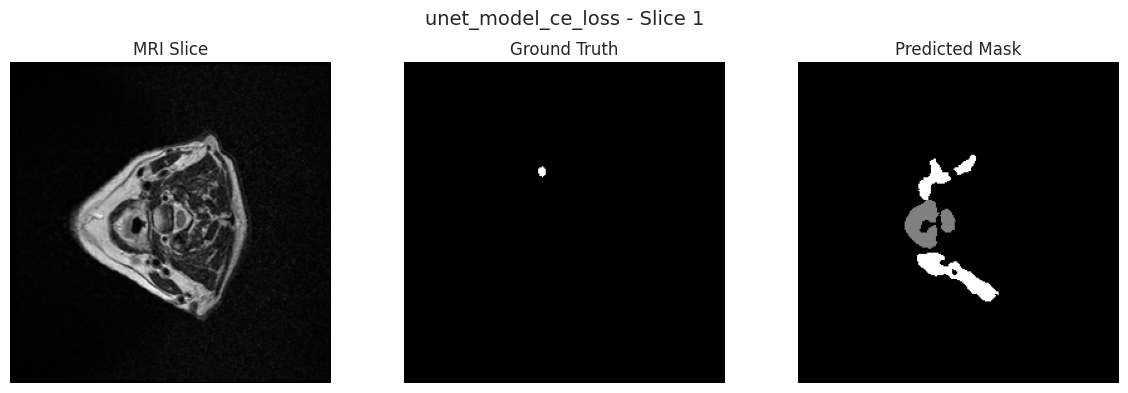

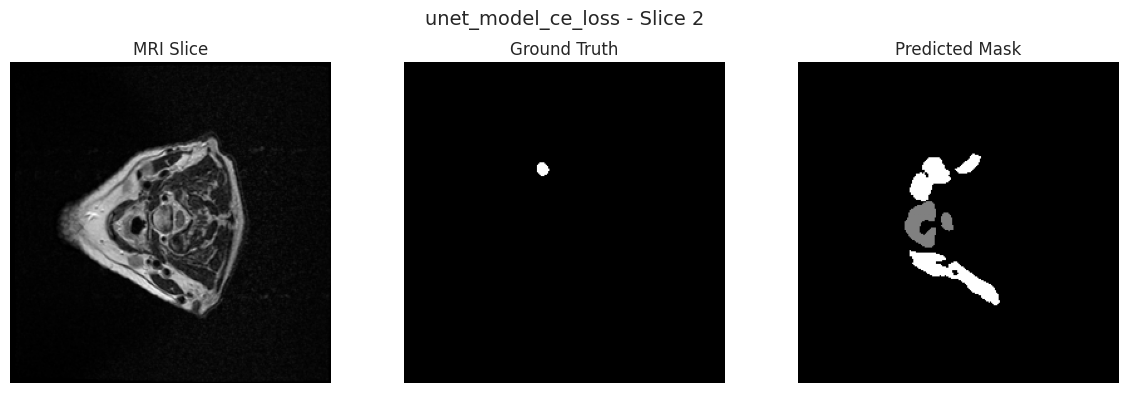

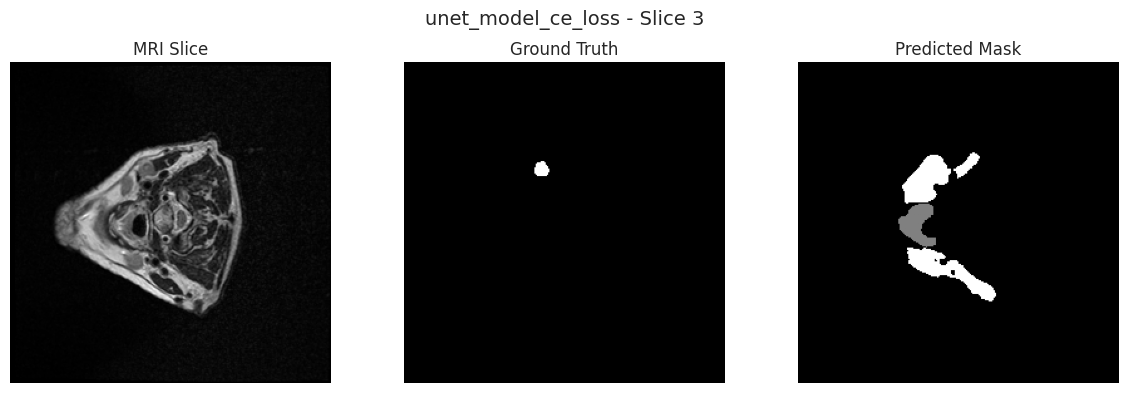


 Evaluating unet_model_combined_loss on test set...
\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9962
    IoU:      0.9923
    Precision:0.9999
    Recall:   0.9924
    F1 Score: 0.9962
  Class 1 (GTVp):
    Dice:     0.1087
    IoU:      0.0575
    Precision:0.0575
    Recall:   0.9860
    F1 Score: 0.1087
  Class 2 (GTVn):
    Dice:     0.3037
    IoU:      0.1790
    Precision:0.1864
    Recall:   0.8185
    F1 Score: 0.3037


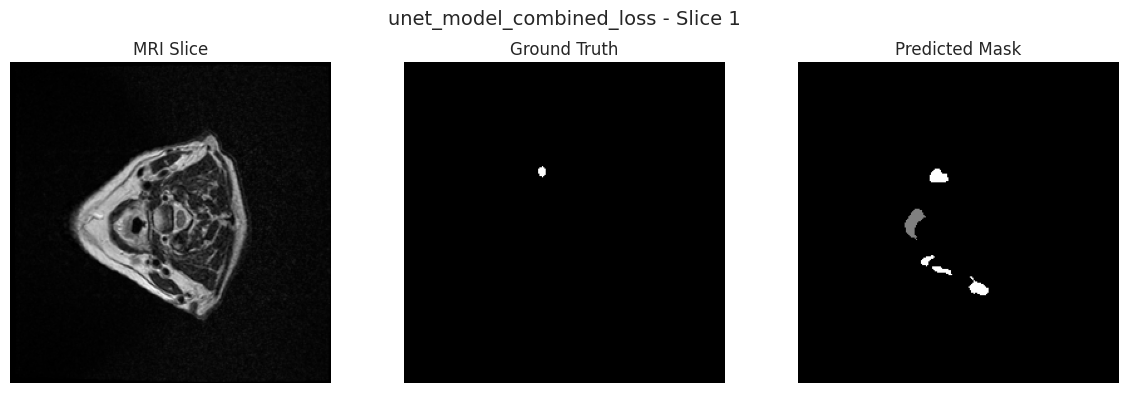

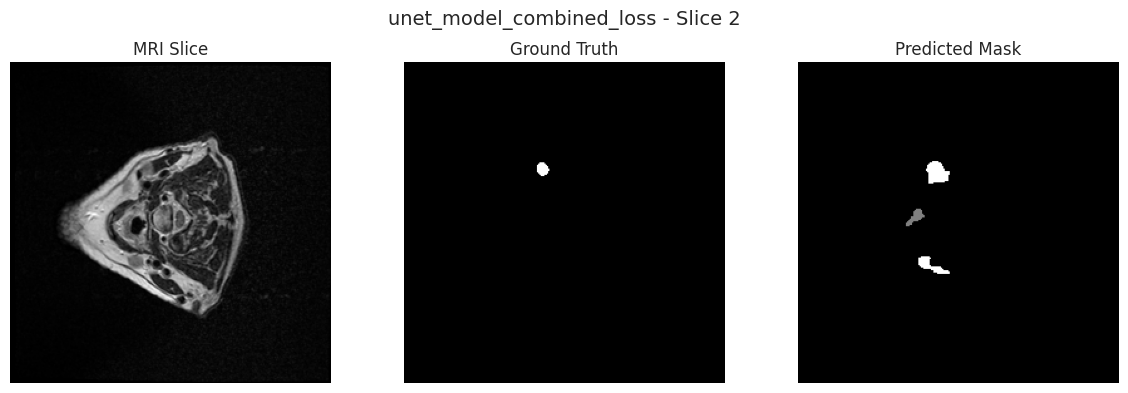

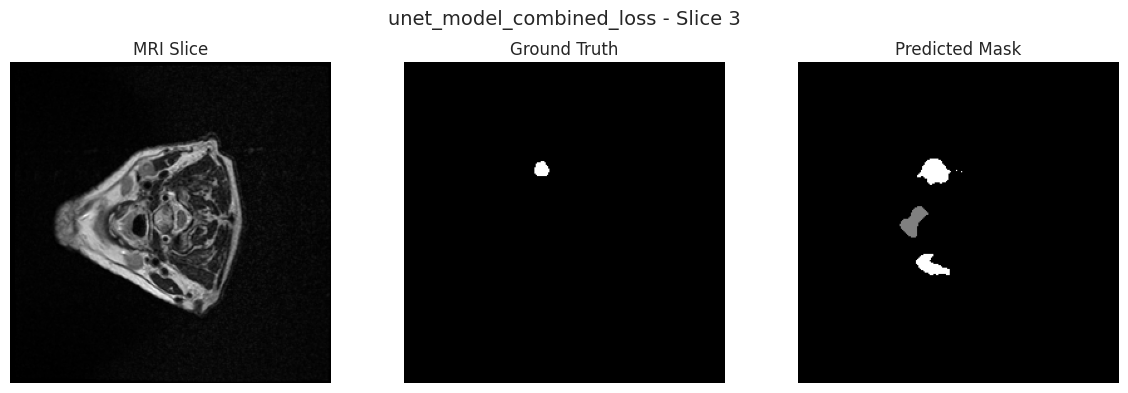


 Evaluating attn_unet_model_ce_loss on test set...
\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9905
    IoU:      0.9811
    Precision:1.0000
    Recall:   0.9811
    F1 Score: 0.9905
  Class 1 (GTVp):
    Dice:     0.0808
    IoU:      0.0421
    Precision:0.0421
    Recall:   0.9774
    F1 Score: 0.0808
  Class 2 (GTVn):
    Dice:     0.0718
    IoU:      0.0373
    Precision:0.0373
    Recall:   0.9402
    F1 Score: 0.0718


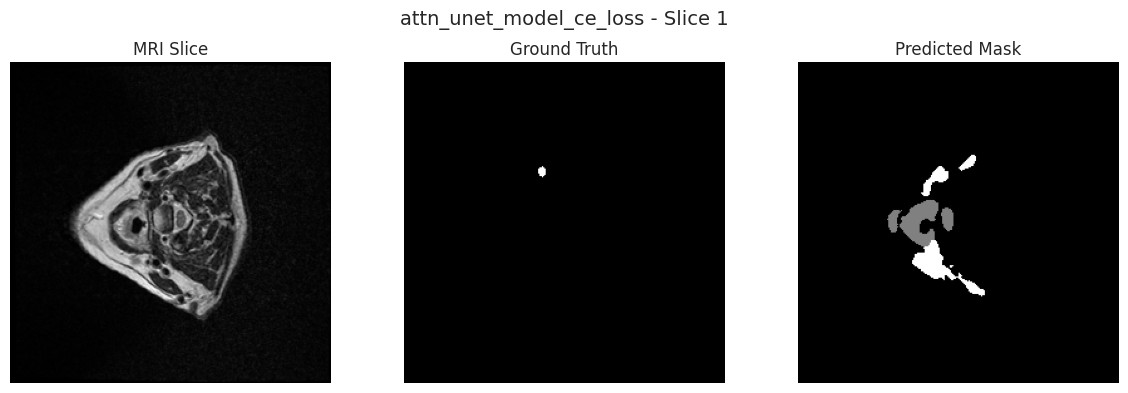

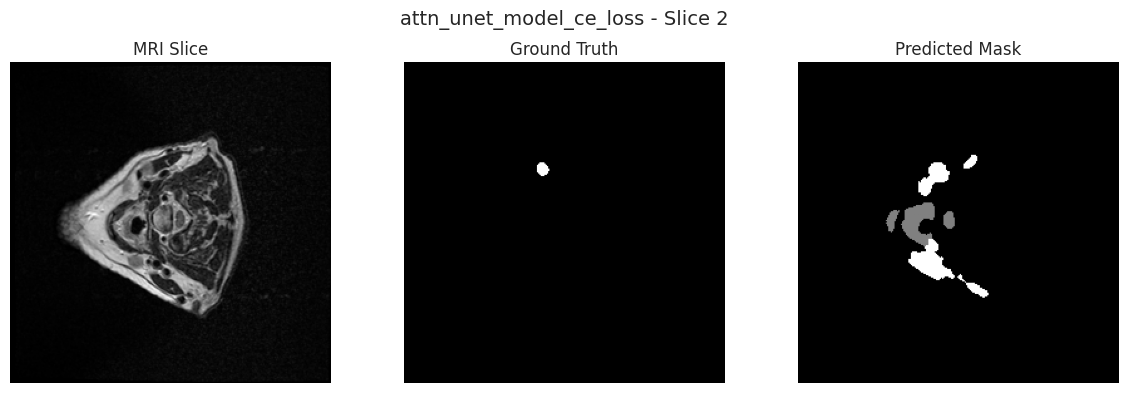

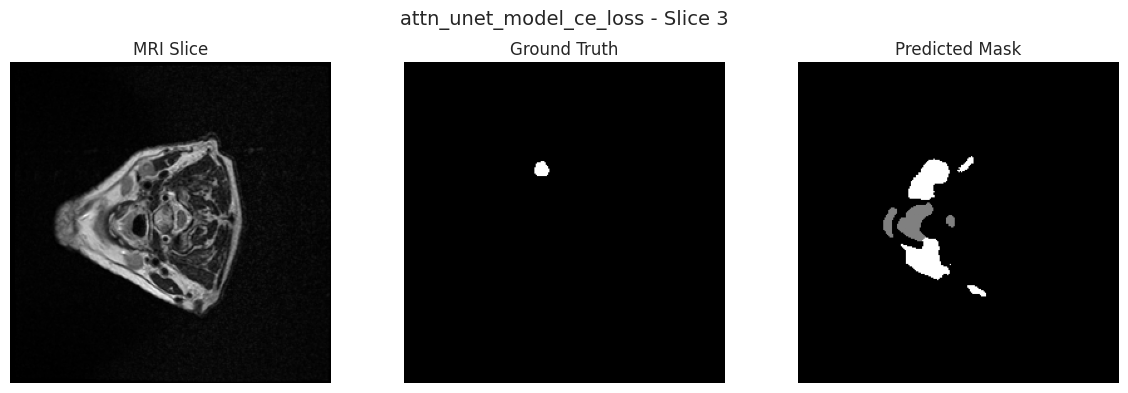


 Evaluating attn_unet_model_combined_loss on test set...
\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9970
    IoU:      0.9940
    Precision:0.9999
    Recall:   0.9941
    F1 Score: 0.9970
  Class 1 (GTVp):
    Dice:     0.1703
    IoU:      0.0930
    Precision:0.0937
    Recall:   0.9269
    F1 Score: 0.1703
  Class 2 (GTVn):
    Dice:     0.2153
    IoU:      0.1206
    Precision:0.1239
    Recall:   0.8178
    F1 Score: 0.2153


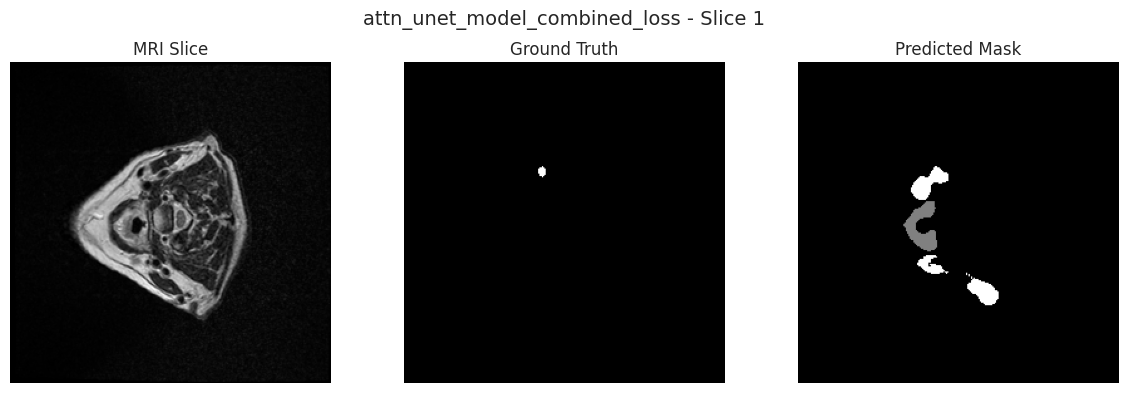

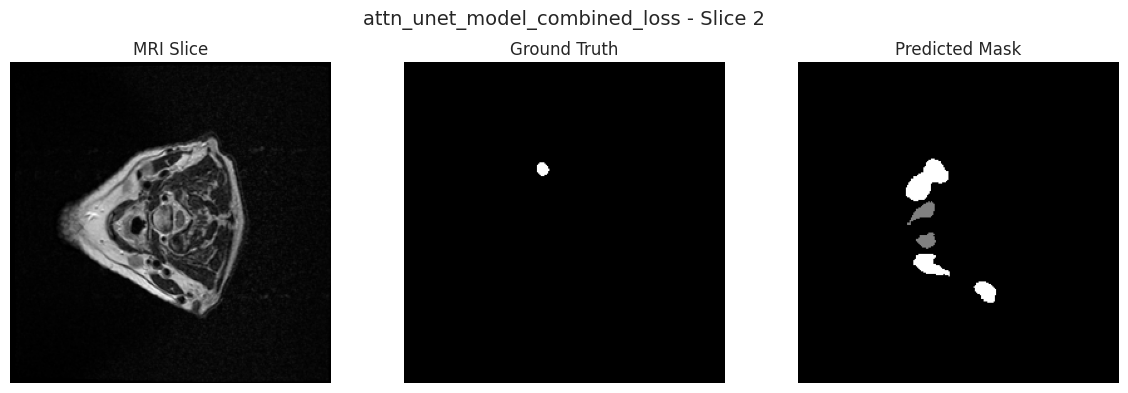

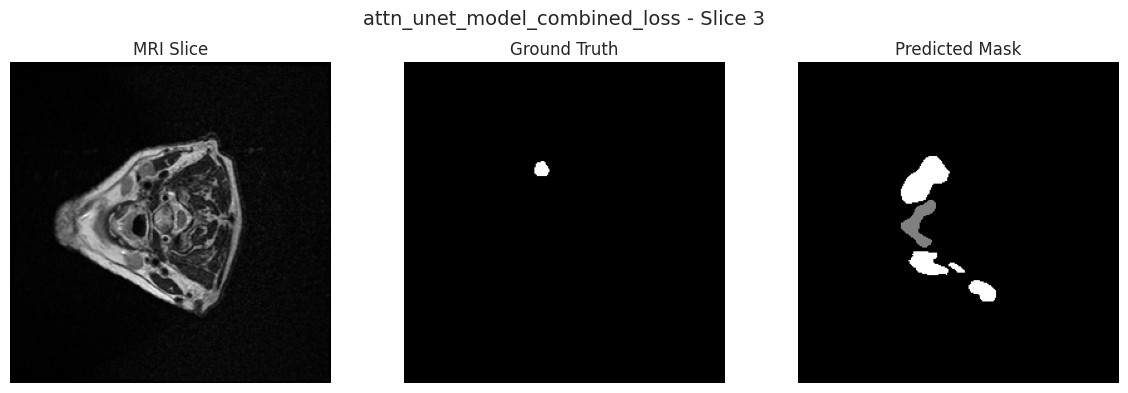


 Evaluating mamba_model_ce_loss on test set...
\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9904
    IoU:      0.9809
    Precision:1.0000
    Recall:   0.9810
    F1 Score: 0.9904
  Class 1 (GTVp):
    Dice:     0.0874
    IoU:      0.0457
    Precision:0.0457
    Recall:   0.9879
    F1 Score: 0.0874
  Class 2 (GTVn):
    Dice:     0.0667
    IoU:      0.0345
    Precision:0.0346
    Recall:   0.9304
    F1 Score: 0.0667


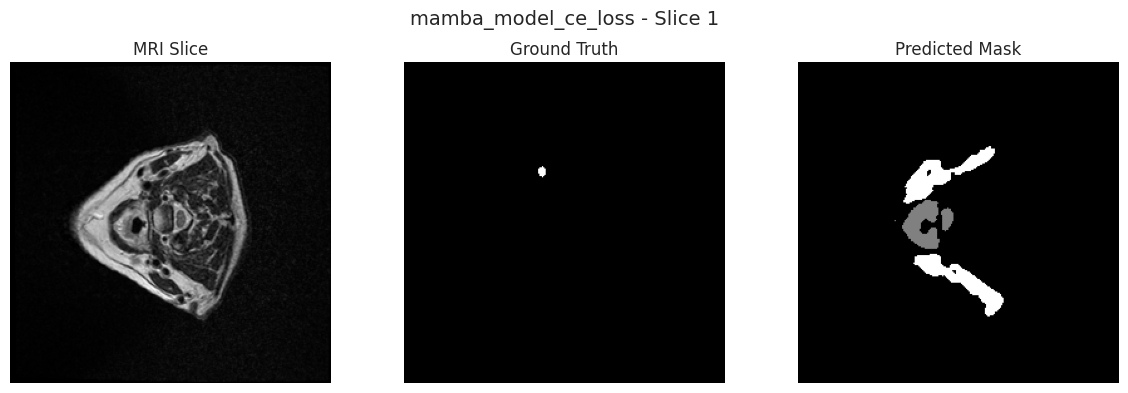

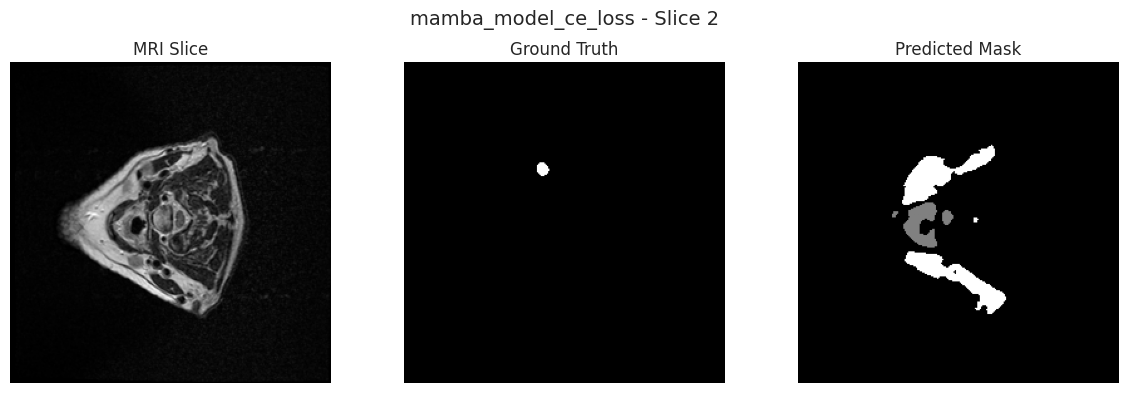

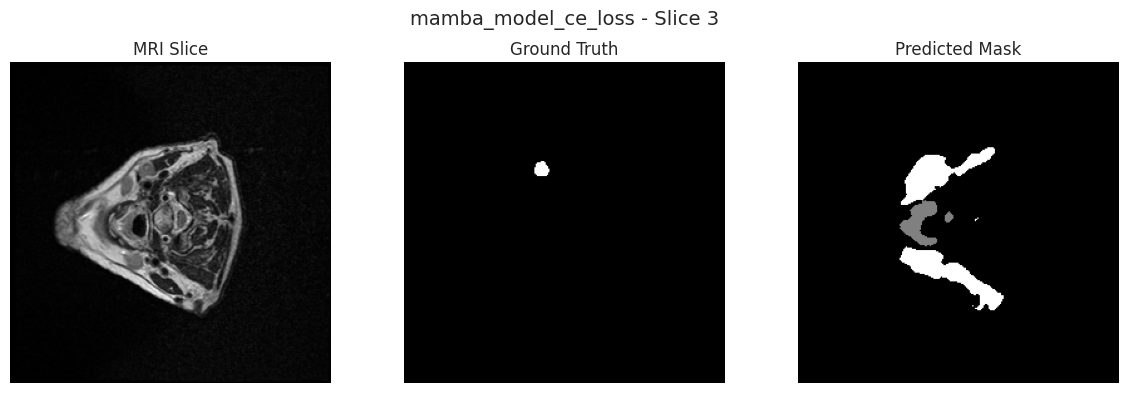


 Evaluating mamba_model_combined_loss on test set...
\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9964
    IoU:      0.9928
    Precision:0.9999
    Recall:   0.9929
    F1 Score: 0.9964
  Class 1 (GTVp):
    Dice:     0.1313
    IoU:      0.0702
    Precision:0.0705
    Recall:   0.9471
    F1 Score: 0.1313
  Class 2 (GTVn):
    Dice:     0.2227
    IoU:      0.1253
    Precision:0.1285
    Recall:   0.8356
    F1 Score: 0.2227


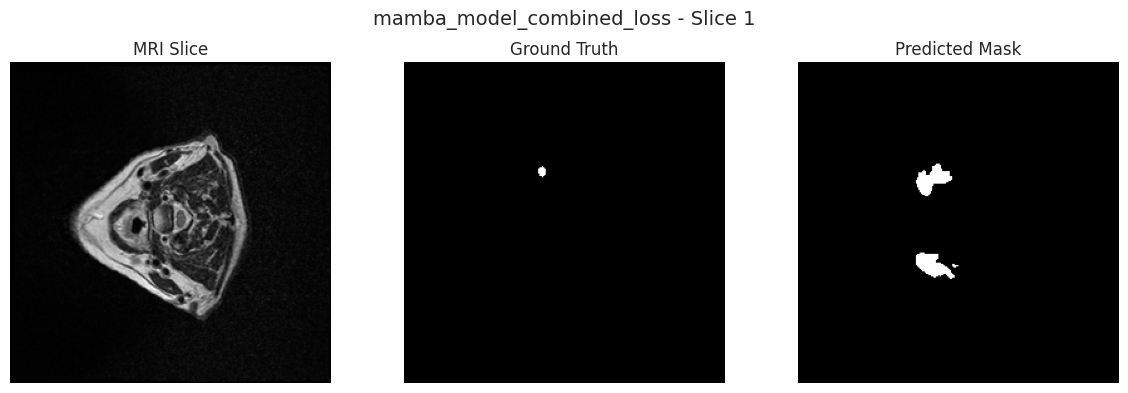

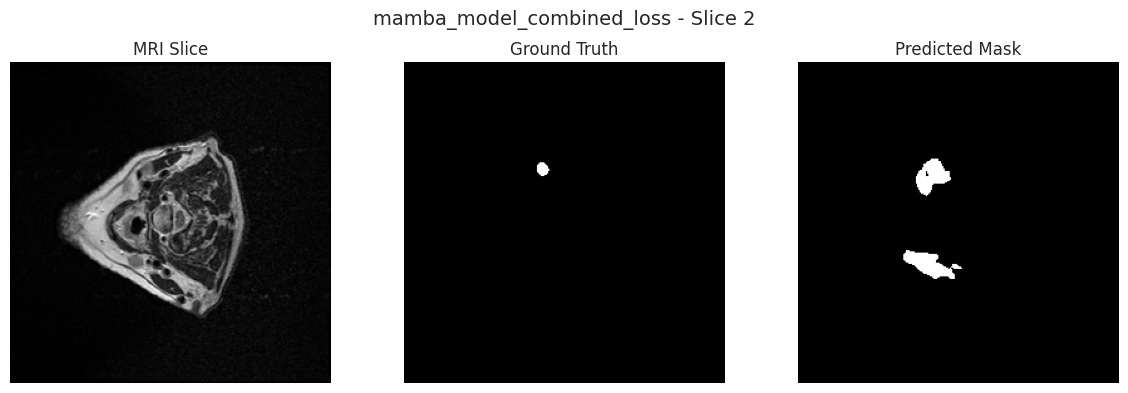

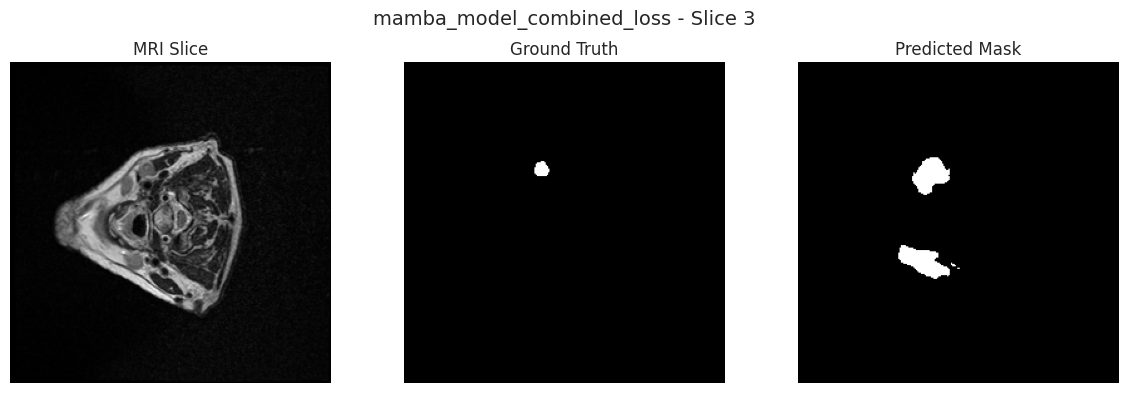

Model not found: /content/drive/MyDrive/cv_mr_data/models/unetplusplus_focal_loss_best.pt
Model not found: /content/drive/MyDrive/cv_mr_data/models/unetplusplus_combined_loss_best.pt

 Evaluating pretrained_unet on test set...
\ Evaluation Metrics (Per Class):
  Class 0 (Background):
    Dice:     0.9955
    IoU:      0.9911
    Precision:0.9999
    Recall:   0.9911
    F1 Score: 0.9955
  Class 1 (GTVp):
    Dice:     0.1093
    IoU:      0.0578
    Precision:0.0580
    Recall:   0.9527
    F1 Score: 0.1093
  Class 2 (GTVn):
    Dice:     0.1888
    IoU:      0.1042
    Precision:0.1063
    Recall:   0.8413
    F1 Score: 0.1888


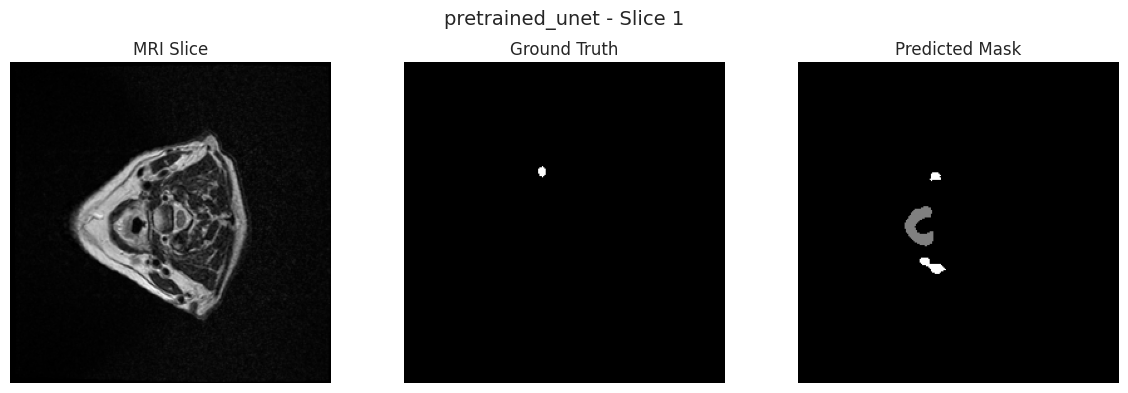

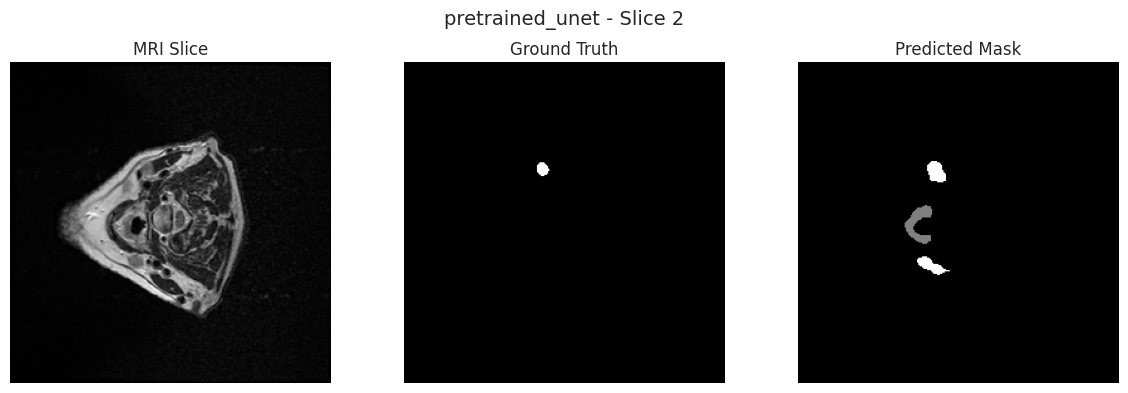

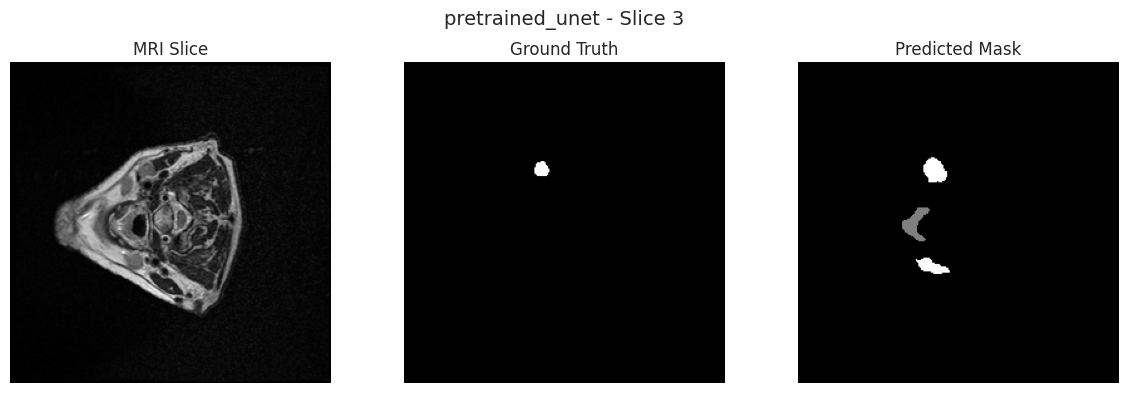


 Final Test Set Results:
                        Model   Dice    IoU  Precision  Recall
           unet_model_ce_loss 0.0940 0.0494     0.0495  0.9593
     unet_model_combined_loss 0.2062 0.1182     0.1220  0.9023
      attn_unet_model_ce_loss 0.0763 0.0397     0.0397  0.9588
attn_unet_model_combined_loss 0.1928 0.1068     0.1088  0.8723
          mamba_model_ce_loss 0.0770 0.0401     0.0401  0.9592
    mamba_model_combined_loss 0.1770 0.0978     0.0995  0.8913
              pretrained_unet 0.1490 0.0810     0.0821  0.8970


In [ ]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load models
model_configs = {
    "unet_model_ce_loss": UNet,
    "unet_model_combined_loss": UNet,
    "attn_unet_model_ce_loss": AttentionUNet,
    "attn_unet_model_combined_loss": AttentionUNet,
    "mamba_model_ce_loss": UMamba,
    "mamba_model_combined_loss": UMamba,
    "unetplusplus_focal_loss": UNetPlusPlus,
    "unetplusplus_combined_loss": UNetPlusPlus,
    "pretrained_unet": UNet,
}

# load data
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dir = "/content/drive/MyDrive/cv_mr_data/models"
test_loader = get_dataloader('/content/drive/MyDrive/cv_mr_data/data/test_slices', batch_size=8, shuffle=False)

# Visualization function
def visualize_predictions(model, dataloader, model_name, device='cuda', num_samples=3):
    import matplotlib.pyplot as plt

    model.eval()
    shown = 0

    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)

        with torch.no_grad():
            logits = model(x_batch)
            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(probs, dim=1)

        for i in range(x_batch.shape[0]):
            mri = x_batch[i].squeeze(0).cpu().numpy()
            gt_mask = y_batch[i].cpu().numpy()
            pred_mask = preds[i].cpu().numpy()

            # Skip slices that are completely empty in ground truth
            if np.max(gt_mask) == 0:
                continue

            plt.figure(figsize=(12, 4))
            plt.suptitle(f"{model_name} - Slice {shown+1}", fontsize=14)

            plt.subplot(1, 3, 1)
            plt.imshow(mri, cmap='gray')
            plt.title("MRI Slice")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(gt_mask, cmap='gray')
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()
            shown += 1

            if shown >= num_samples:
                return

# evalude models on test set
results = []

for model_name, model_class in model_configs.items():
    model_path = os.path.join(model_dir, f"{model_name}_best.pt")

    if not os.path.exists(model_path):
        print(f"Model not found: {model_path}")
        continue

    print(f"\n Evaluating {model_name} on test set...")
    model = model_class(in_channels=1, num_classes=3).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))

    metrics = evaluate_model(model, test_loader, device=device, num_classes=3)

    results.append({
        "Model": model_name,
        "Dice": round(metrics["dice"], 4),
        "IoU": round(metrics["iou"], 4),
        "Precision": round(metrics["precision"], 4),
        "Recall": round(metrics["recall"], 4)
    })

    # Show sample outputs
    visualize_predictions(model, test_loader, model_name, device=device)

# --- Final summary table ---
df = pd.DataFrame(results)
print("\n Final Test Set Results:")
print(df.to_string(index=False))

# Conclusion

This project focused on developing a 2D frame-by-frame segmentation pipeline for identifying head and neck tumors using T2-weighted MRI scans from the HNTSMRG2024 dataset. I trained and evaluated a range of U-Net-based architectures — including vanilla U-Net, Attention U-Net, U-Net++, and a Mamba-inspired variant — using different loss functions: cross-entropy, Dice, and a combined Dice + CE loss. A major challenge throughout was the extreme class imbalance, with the majority of MRI slices containing no tumor at all.

Before training, I performed several preprocessing steps. All slices were resized to 256×256 pixels to ensure uniform input size and MRI volumes were normalized for intensity (z-score normalization) on a per-volume basis. I extracted slices from both preRT and midRT scans and created a metadata-driven stratified train/val/test split based on tumor presence. To reduce RAM usage, each slice and its corresponding mask were saved as individual .pt files. I also wrote custom scripts to validate, clean, and summarize class distributions, including identifying slices with empty masks.

Cross-entropy alone gave models high recall but very poor precision — meaning the networks were overly aggressive in predicting tumor pixels. Dice loss alone didn’t work well either. The best-performing setup was a basic U-Net trained with the combined Dice + CE loss, which consistently achieved the highest Dice and IoU scores across validation and test sets. More complex models like Attention U-Net and Mamba didn’t show significant improvements, likely due to the limitations of 2D segmentation and the small dataset size.

Given the poor results across most models, I also tried training a U-Net exclusively on slices that contained tumors. This had some effect: recall stayed high, and Dice improved slightly compared to the same model trained on the full dataset. However, the gain wasn’t large enough to justify adopting it as the final approach — though it did reinforce that including thousands of empty slices was likely hurting performance.

In the future, I’d focus on using only middle slices during training — where tumors are actually visible — and explore 3D segmentation or multi-slice input to give the model more context. Overall, the vanilla U-Net with combined loss performed best, and would be my final model for test-time inference.